# Objective

In this hackathon, you’ll get to test your multistep time series forecasting skills with exogenous data! The objective is to forecast pollution levels for the next seven days.

The data.csv file contains three columns: time, PM2.5 and exog. The PM2.5 corresponds to the pollutant readings at each hour, which is what you want to predict. The exog corresponds to the wind speed forecast, which is the exogenous data that may be useful to make your predictions. Note that the last 168 values of the PM2.5 are missing, because these correspond to the values you are expected to predict.

# Context

PM2.5 are particulate matter (PM) that have a diameter less than 2.5 micrometers. These are some of the most dangerous pollutants and increase the risk of getting diseases like respiratory infections, lung cancer, and heart disease. Accurate forecasting of these pollutants with appropriate lead time can help implement more effective policies in cities with high levels of pollution.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import 
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler

In [2]:
plt.rcParams['figure.figsize'] =  (15,5)
plt.rcParams['font.sans-serif'] = 'Open Sans'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#4c4c4c'
plt.rcParams['axes.labelcolor']= '#4c4c4c'
plt.rcParams['xtick.color'] = '#4c4c4c'
plt.rcParams['ytick.color'] = '#4c4c4c'
plt.rcParams['font.size']=12

In [3]:
sns.set_context("notebook", font_scale=1.3)
sns.set(style='whitegrid')

# To import the data

In [5]:
path = "/Users/fabienguegan/projects/batch6-students/S03 - Time Series/HCKT03 - Time Series Forecasting/data/"

In [6]:
data = pd.read_csv(path + "data.csv")

In [7]:
data

,date,PM2.5,exog
0,2013-03-01 00:00:00,4.0,4.4
1,2013-03-01 01:00:00,8.0,4.7
2,2013-03-01 02:00:00,7.0,5.6
3,2013-03-01 03:00:00,6.0,3.1
4,2013-03-01 04:00:00,3.0,2.0
...,...,...,...
34891,2017-02-21 19:00:00,NaN,1.4
34892,2017-02-21 20:00:00,NaN,1.5
34893,2017-02-21 21:00:00,NaN,1.1
34894,2017-02-21 22:00:00,NaN,1.7


# To arrange the dataset and convert date column to Datetime

## To split the dataset between "train" and "test" data (the last 168 values of the PM2.5 are missing, because these correspond to the values you are expected to predict.)

In [8]:
train_data = data.iloc[:-168,:]
test_data = data.iloc[-168:,:]

In [9]:
train_data

,date,PM2.5,exog
0,2013-03-01 00:00:00,4.0,4.4
1,2013-03-01 01:00:00,8.0,4.7
2,2013-03-01 02:00:00,7.0,5.6
3,2013-03-01 03:00:00,6.0,3.1
4,2013-03-01 04:00:00,3.0,2.0
...,...,...,...
34723,2017-02-14 19:00:00,210.0,1.1
34724,2017-02-14 20:00:00,211.0,0.2
34725,2017-02-14 21:00:00,227.0,1.0
34726,2017-02-14 22:00:00,247.0,1.0


In [10]:
test_data

,date,PM2.5,exog
34728,2017-02-15 00:00:00,NaN,0.0
34729,2017-02-15 01:00:00,NaN,0.6
34730,2017-02-15 02:00:00,NaN,0.2
34731,2017-02-15 03:00:00,NaN,1.7
34732,2017-02-15 04:00:00,NaN,1.1
...,...,...,...
34891,2017-02-21 19:00:00,NaN,1.4
34892,2017-02-21 20:00:00,NaN,1.5
34893,2017-02-21 21:00:00,NaN,1.1
34894,2017-02-21 22:00:00,NaN,1.7


## To convert the date column to Datetime

In [11]:
train_data_dt = train_data.copy()
test_data_dt = test_data.copy()

In [12]:
train_data_dt

,date,PM2.5,exog
0,2013-03-01 00:00:00,4.0,4.4
1,2013-03-01 01:00:00,8.0,4.7
2,2013-03-01 02:00:00,7.0,5.6
3,2013-03-01 03:00:00,6.0,3.1
4,2013-03-01 04:00:00,3.0,2.0
...,...,...,...
34723,2017-02-14 19:00:00,210.0,1.1
34724,2017-02-14 20:00:00,211.0,0.2
34725,2017-02-14 21:00:00,227.0,1.0
34726,2017-02-14 22:00:00,247.0,1.0


In [13]:
train_data_dt.date = pd.to_datetime(train_data_dt['date'])
test_data_dt.date = pd.to_datetime(test_data_dt['date'])

In [14]:
train_data_dt

,date,PM2.5,exog
0,2013-03-01 00:00:00,4.0,4.4
1,2013-03-01 01:00:00,8.0,4.7
2,2013-03-01 02:00:00,7.0,5.6
3,2013-03-01 03:00:00,6.0,3.1
4,2013-03-01 04:00:00,3.0,2.0
...,...,...,...
34723,2017-02-14 19:00:00,210.0,1.1
34724,2017-02-14 20:00:00,211.0,0.2
34725,2017-02-14 21:00:00,227.0,1.0
34726,2017-02-14 22:00:00,247.0,1.0


## To set the Datetime as index of the "train" and "test" dataset

In [15]:
train_data_dt = train_data_dt.set_index('date',    # <---- Set the index to be our timestamp data  
                      drop=True).asfreq('H')      # <---- drop the original column

test_data_dt = test_data_dt.set_index('date',    # <---- Set the index to be our timestamp data  
                      drop=True).asfreq('H')     # <---- drop the original column

In [16]:
train_data_dt.head(5)

,PM2.5,exog
date,,
2013-03-01 00:00:00,4.0,4.4
2013-03-01 01:00:00,8.0,4.7
2013-03-01 02:00:00,7.0,5.6
2013-03-01 03:00:00,6.0,3.1
2013-03-01 04:00:00,3.0,2.0


In [17]:
test_data_dt.head(5)

,PM2.5,exog
date,,
2017-02-15 00:00:00,NaN,0.0
2017-02-15 01:00:00,NaN,0.6
2017-02-15 02:00:00,NaN,0.2
2017-02-15 03:00:00,NaN,1.7
2017-02-15 04:00:00,NaN,1.1


## To fill the missing data from "train" dataset

There no missing data in test_data_dt (execpt the PM2.5 values that we should predict) 

In [18]:
test_data_dt.isnull().sum()

PM2.5    168
exog       0
dtype: int64

In [19]:
train_data_dt.isnull().sum()

PM2.5    911
exog      14
dtype: int64

In [20]:
train_data_dt[train_data_dt["PM2.5"].isnull()==True]

,PM2.5,exog
date,,
2013-05-02 21:00:00,NaN,2.8
2013-05-16 13:00:00,NaN,2.7
2013-06-07 16:00:00,NaN,0.8
2013-06-25 01:00:00,NaN,0.2
2013-06-26 00:00:00,NaN,0.4
...,...,...
2016-11-24 14:00:00,NaN,1.8
2016-11-24 15:00:00,NaN,2.3
2016-12-27 18:00:00,NaN,3.2


Here an example of missing data for PM2.5 on the 2013-05-02 at 21:00:00

<AxesSubplot: xlabel='date'>

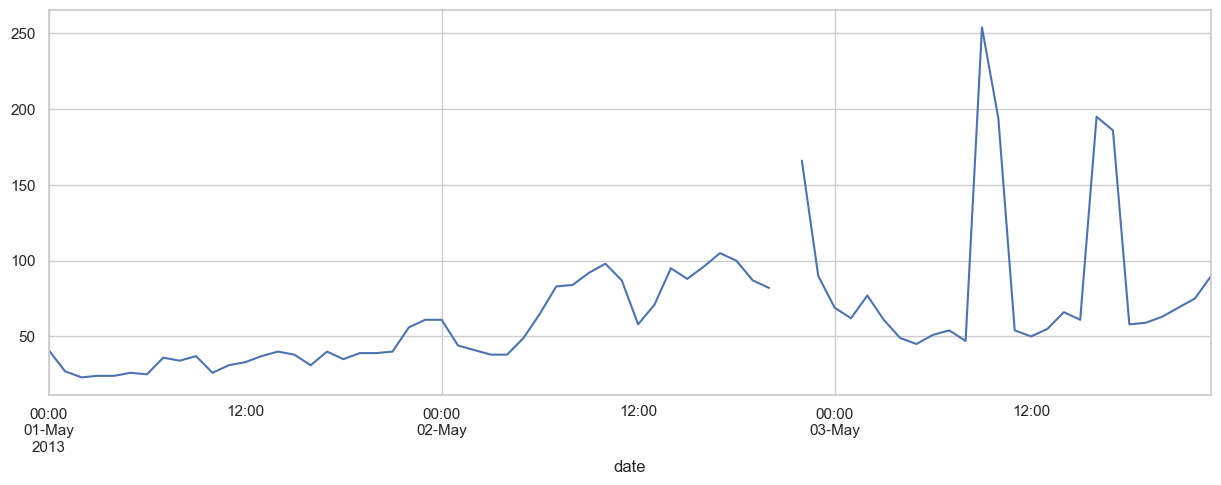

In [21]:
train_data_dt["PM2.5"].loc["2013-05-01":"2013-05-03"].plot()

### To use the linear interpolation ( pd.DataFrame.interpolate( ) )

In [22]:
train_data_dt_interpolate = train_data_dt.copy()

<AxesSubplot: xlabel='date'>

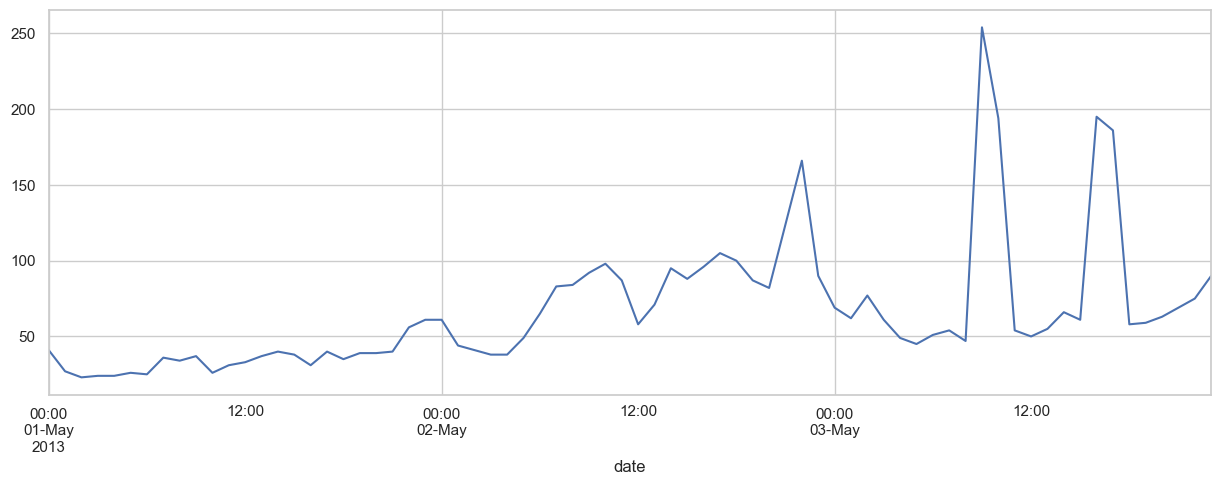

In [23]:
train_data_dt_interpolate["PM2.5"].loc["2013-05-01":"2013-05-03"].interpolate().plot()

Let's do it for all the PM2.5 missing data

In [24]:
train_data_dt_interpolate["PM2.5"] = train_data_dt_interpolate["PM2.5"].interpolate()

In [25]:
train_data_dt_interpolate.isnull().sum()

PM2.5     0
exog     14
dtype: int64

There are also missing values for the exogenous data

Let's handle it as we did for the PM2.5 column

In [26]:
train_data_dt_interpolate[train_data_dt_interpolate["exog"].isnull()]

,PM2.5,exog
date,,
2015-01-27 20:00:00,26.0,NaN
2015-02-18 07:00:00,13.0,NaN
2016-09-25 19:00:00,168.0,NaN
2016-09-25 20:00:00,182.0,NaN
2016-09-25 21:00:00,137.0,NaN
2016-09-25 22:00:00,107.0,NaN
2016-09-25 23:00:00,95.0,NaN
2017-01-19 03:00:00,96.0,NaN
2017-01-19 04:00:00,112.0,NaN


<AxesSubplot: xlabel='date'>

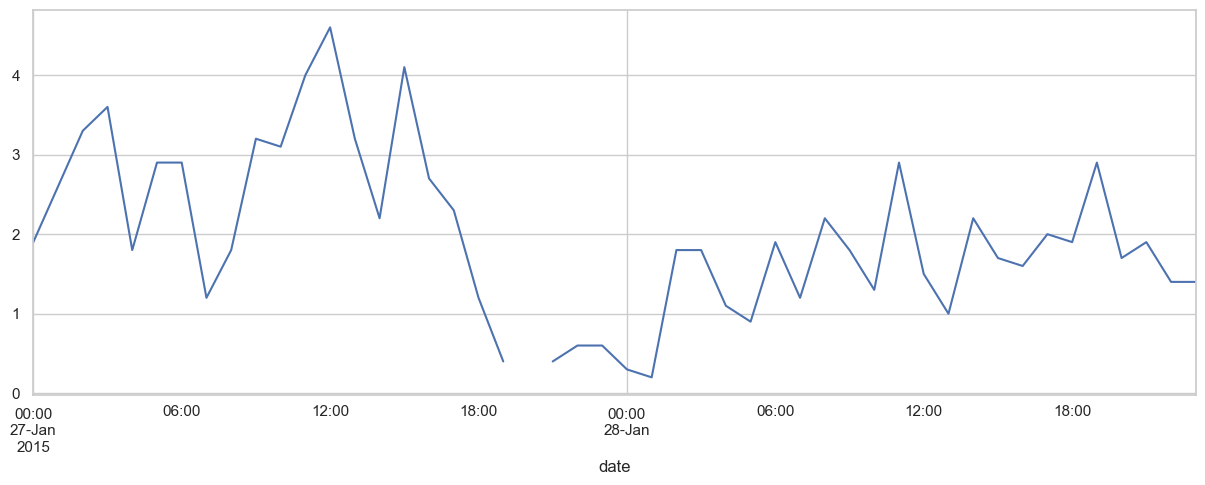

In [27]:
train_data_dt_interpolate["exog"].loc["2015-01-27":"2015-01-28"].plot()

<AxesSubplot: xlabel='date'>

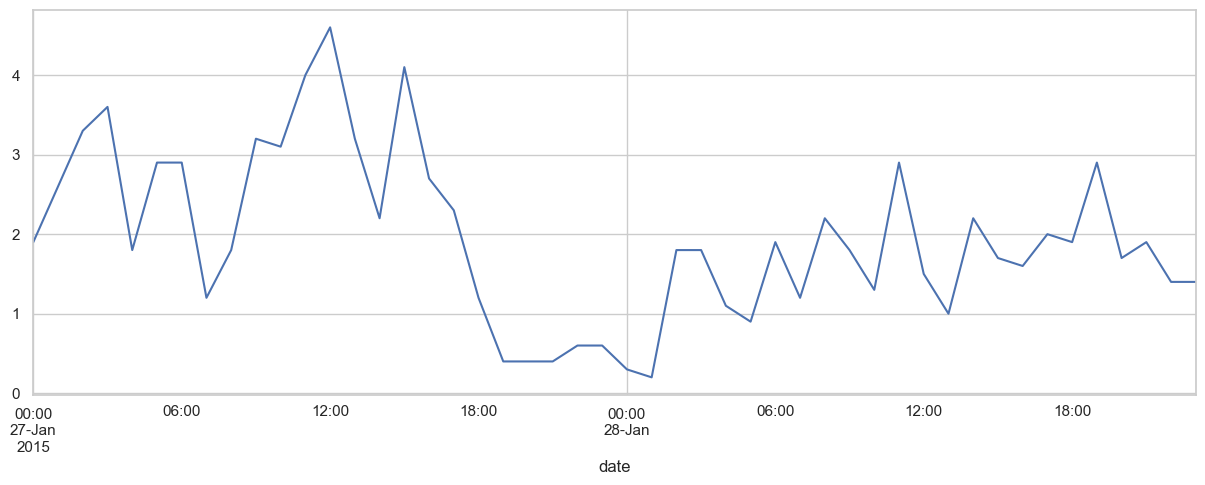

In [29]:
train_data_dt_interpolate["exog"].loc["2015-01-27":"2015-01-28"].interpolate().plot()

Let's do it for all the exog missing data

In [28]:
train_data_dt_interpolate["exog"] = train_data_dt_interpolate["exog"].interpolate()

In [29]:
train_data_dt_interpolate.isnull().sum()

PM2.5    0
exog     0
dtype: int64

There is a problem in filling the missing PM2.5 values in december 2014 (too many following missing values) 

<AxesSubplot: xlabel='date'>

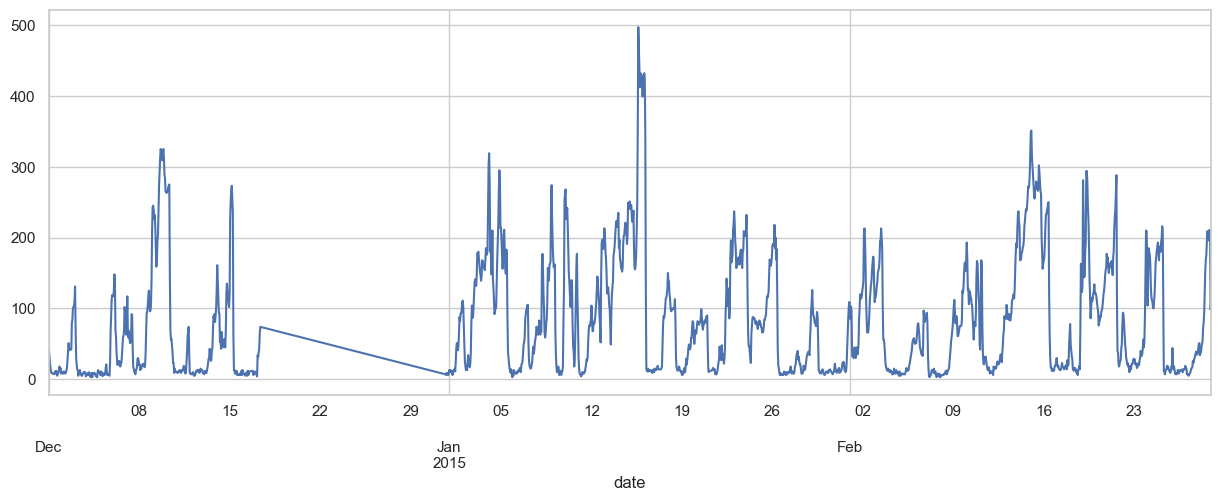

In [30]:
train_data_dt_interpolate["PM2.5"].loc["2014-12":"2015-02"].plot()

It will be better to use KNNImputer (as we learned in the learning notebook #1) 

In [31]:
imputer = KNNImputer()
data_imputed = imputer.fit_transform(train_data_dt)

<AxesSubplot: xlabel='date'>

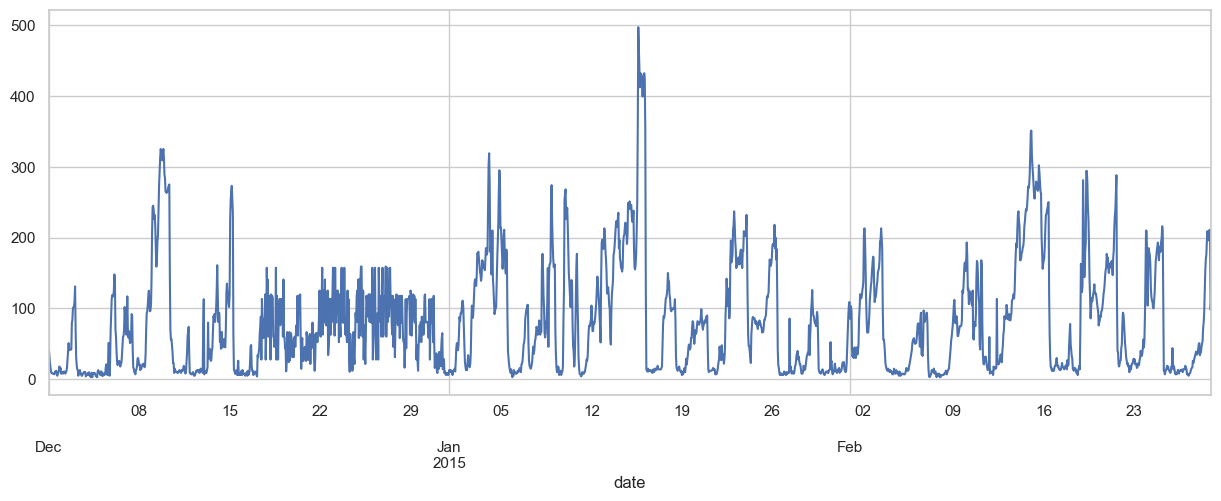

In [32]:
interval = slice("2014-12", "2015-02")
df_imputed = pd.DataFrame(data_imputed, index=train_data_dt.index, columns=train_data_dt.columns)
df_imputed.loc[interval]["PM2.5"].plot()

In [33]:
df_imputed.isnull().sum()

PM2.5    0
exog     0
dtype: int64

### To create exog dataset without missing values

In [34]:
train_exog = df_imputed["exog"]
train_exog 

date
2013-03-01 00:00:00    4.4
2013-03-01 01:00:00    4.7
2013-03-01 02:00:00    5.6
2013-03-01 03:00:00    3.1
2013-03-01 04:00:00    2.0
                      ... 
2017-02-14 19:00:00    1.1
2017-02-14 20:00:00    0.2
2017-02-14 21:00:00    1.0
2017-02-14 22:00:00    1.0
2017-02-14 23:00:00    0.8
Freq: H, Name: exog, Length: 34728, dtype: float64

In [35]:
test_exog = test_data_dt["exog"]
test_exog 

date
2017-02-15 00:00:00    0.0
2017-02-15 01:00:00    0.6
2017-02-15 02:00:00    0.2
2017-02-15 03:00:00    1.7
2017-02-15 04:00:00    1.1
                      ... 
2017-02-21 19:00:00    1.4
2017-02-21 20:00:00    1.5
2017-02-21 21:00:00    1.1
2017-02-21 22:00:00    1.7
2017-02-21 23:00:00    2.0
Freq: H, Name: exog, Length: 168, dtype: float64

Concat train_exog and test_exog

In [36]:
data_exog = pd.concat([train_exog, test_exog])
data_exog

date
2013-03-01 00:00:00    4.4
2013-03-01 01:00:00    4.7
2013-03-01 02:00:00    5.6
2013-03-01 03:00:00    3.1
2013-03-01 04:00:00    2.0
                      ... 
2017-02-21 19:00:00    1.4
2017-02-21 20:00:00    1.5
2017-02-21 21:00:00    1.1
2017-02-21 22:00:00    1.7
2017-02-21 23:00:00    2.0
Freq: H, Name: exog, Length: 34896, dtype: float64

### To create PM2.5 dataset

In [37]:
train_PM = pd.DataFrame(df_imputed["PM2.5"])
train_PM

,PM2.5
date,
2013-03-01 00:00:00,4.0
2013-03-01 01:00:00,8.0
2013-03-01 02:00:00,7.0
2013-03-01 03:00:00,6.0
2013-03-01 04:00:00,3.0
...,...
2017-02-14 19:00:00,210.0
2017-02-14 20:00:00,211.0
2017-02-14 21:00:00,227.0


# EDA and Data visualization

## To check the overall trend of the PM2.5 dataset

In [146]:
graph_x = train_PM.reset_index().index.values.reshape(-1, 1)

In [147]:
train_PM_reset = train_PM.reset_index()["PM2.5"]

In [148]:
slr = LinearRegression(fit_intercept=True)

slr.fit(graph_x, train_PM_reset)

linear_trend = pd.Series(slr.predict(graph_x), index=train_PM.index)

linear trend coef:  [-0.00017728]


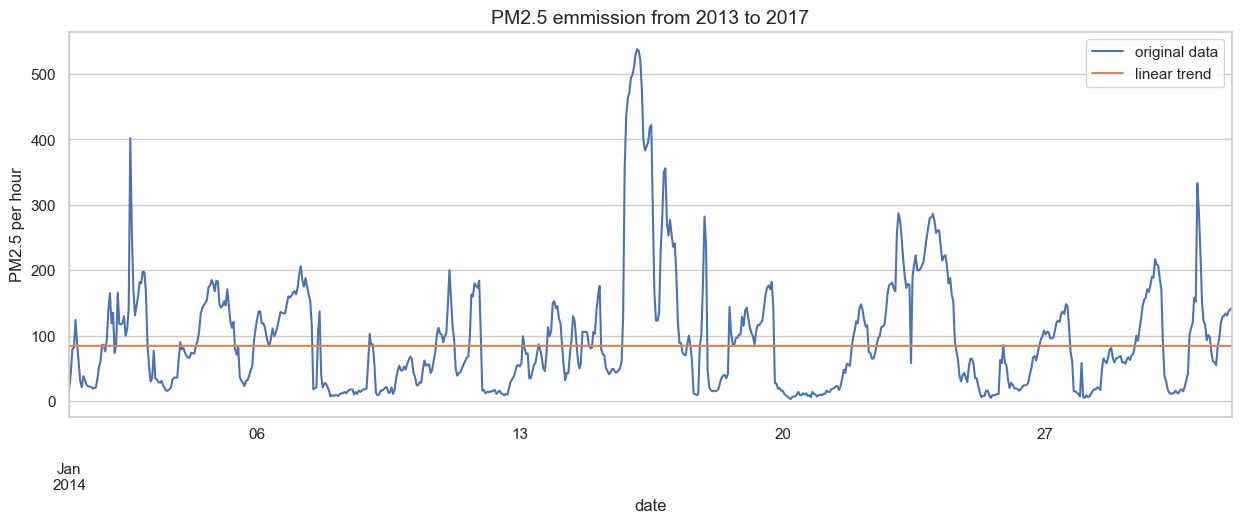

In [149]:
train_PM["PM2.5"].loc["2014-01"].plot(label="original data")
linear_trend.loc["2014-01"].plot(label="linear trend")
plt.ylabel('PM2.5 per hour')
plt.title("PM2.5 emmission from 2013 to 2017", size=14)
plt.legend();
print("linear trend coef: ", slr.coef_)

There is no real trend fro the PM2.5 dataset. Only a small decrease overtime with coef_ = -0.00017728

## To reduce the trend using log transformation

In [150]:
train_PM_log = np.log(train_PM)

In [151]:
train_PM_log_reset = train_PM_log.reset_index()["PM2.5"]

In [152]:
slr.fit(graph_x, train_PM_log_reset)

linear_trend_logged = pd.Series(slr.predict(graph_x), index=train_PM.index)

linear trend logged coef:  [-7.65232736e-06]


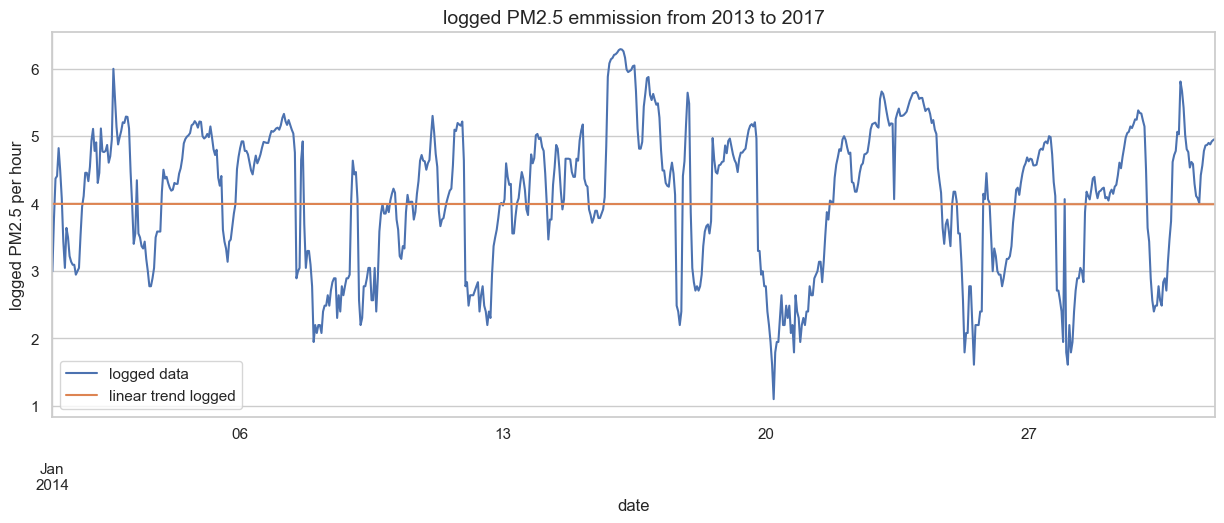

In [153]:
train_PM_log["PM2.5"].loc["2014-01"].plot(label="logged data")
linear_trend_logged.loc["2014-01"].plot(label="linear trend logged")
plt.ylabel('logged PM2.5 per hour')
plt.title("logged PM2.5 emmission from 2013 to 2017", size=14)
plt.legend();
print("linear trend logged coef: ", slr.coef_)

## Rolling/Moving average

Rolling of 1 week (=168 hours)

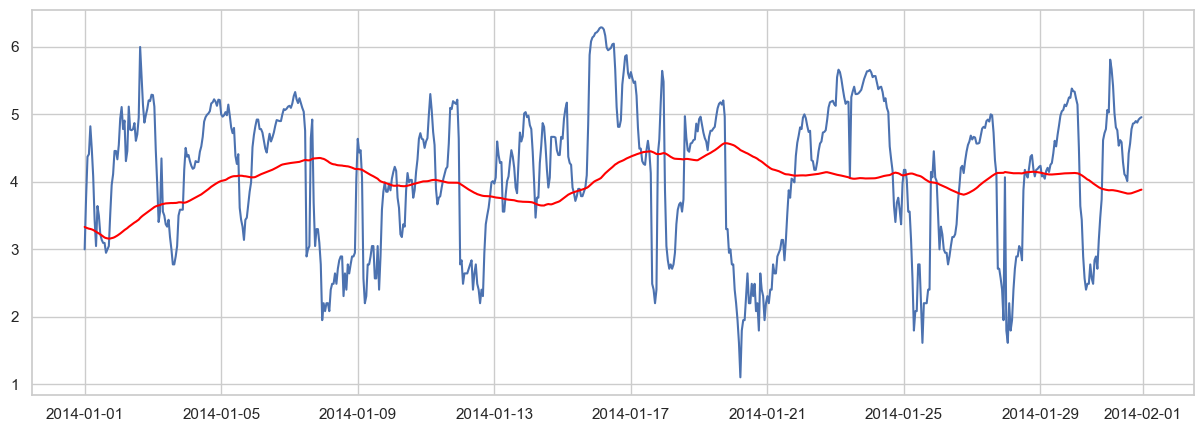

In [154]:
moving_average_mean = train_PM_log.rolling(168).mean()
moving_average_std = train_PM_log.rolling(168).std()
plt.plot(train_PM_log.loc["2014-01"])
plt.plot(moving_average_mean.loc["2014-01"], color="red")

In [155]:
train_PM_log_moving_avg_diff = train_PM_log - moving_average_mean
moving_average_mean_diff = train_PM_log_moving_avg_diff.dropna().rolling(168).mean()
moving_average_std_diff = train_PM_log_moving_avg_diff.dropna().rolling(168).std()

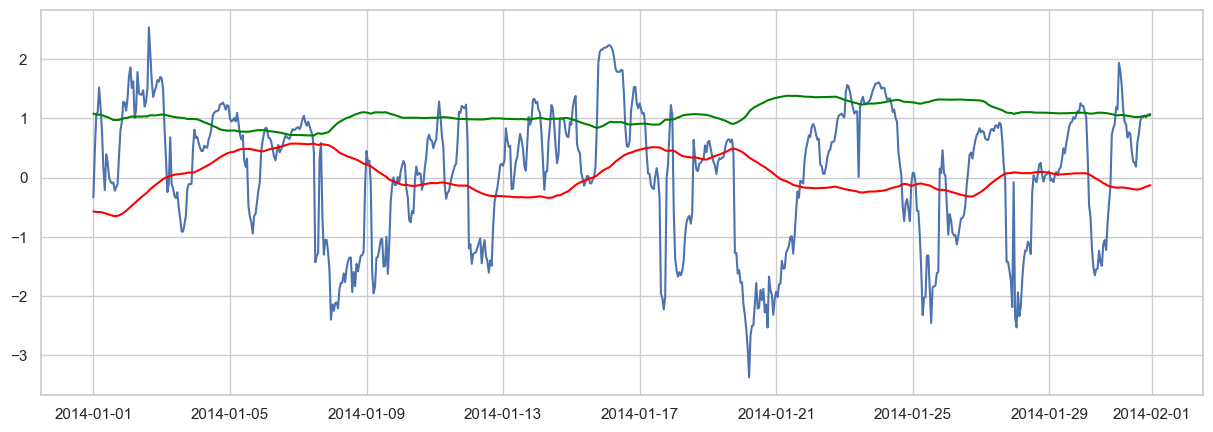

In [156]:
plt.plot(train_PM_log_moving_avg_diff.loc["2014-01"])
plt.plot(moving_average_mean_diff.loc["2014-01"], color="red")
plt.plot(moving_average_std_diff.loc["2014-01"], color="green")

In [157]:
dftest = adfuller(train_PM_log_moving_avg_diff.dropna(), autolag="AIC")

In [158]:
dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations used"])

for key, value in dftest[4].items():
    dfoutput[f"Critical Value {key}"] = value

print(dfoutput)
    

Test Statistic                   -22.424728
p-value                            0.000000
#Lags Used                        51.000000
Number of Observations used    34509.000000
Critical Value 1%                 -3.430540
Critical Value 5%                 -2.861624
Critical Value 10%                -2.566815
dtype: float64


## Seasonality (along with trend)

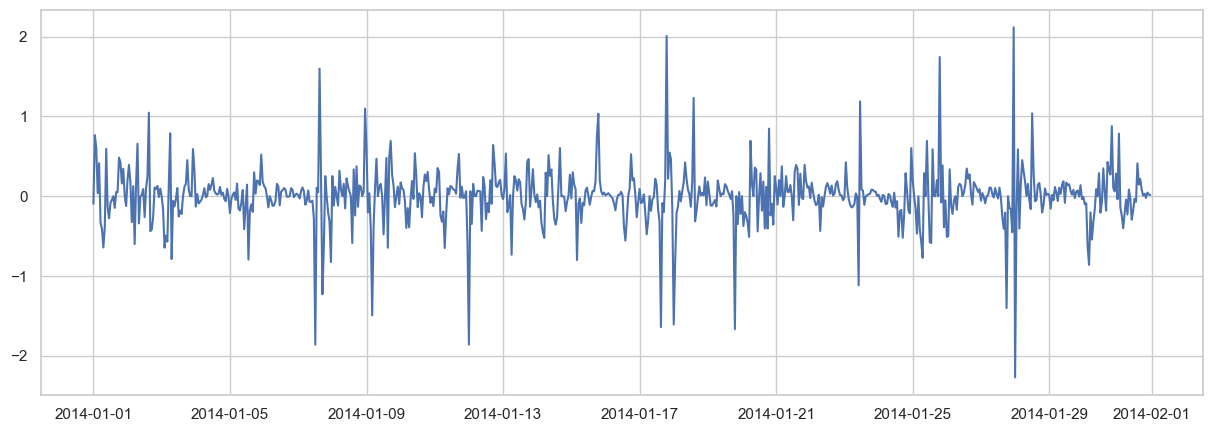

In [50]:
train_PM_log_diff = train_PM_log - train_PM_log.shift()
plt.plot(train_PM_log_diff.loc["2014-01"])

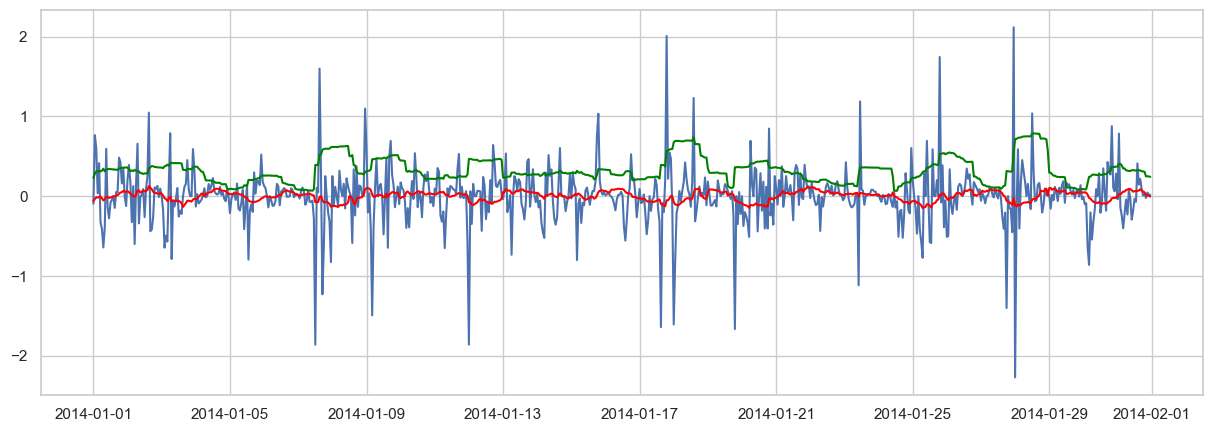

In [51]:
plt.plot(train_PM_log_diff.dropna().loc["2014-01"])
plt.plot(train_PM_log_diff.dropna().rolling(24).mean().dropna().loc["2014-01"], color="red")
plt.plot(train_PM_log_diff.dropna().rolling(24).std().dropna().loc["2014-01"], color="green")

In [55]:
dftest_seasonality = adfuller(train_PM_log_diff.dropna(), autolag="AIC")

In [56]:
dfoutput_seasonality = pd.Series(dftest_seasonality[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations used"])

for key, value in dftest_seasonality[4].items():
    dfoutput_seasonality[f"Critical Value {key}"] = value

print(dfoutput_seasonality)

Test Statistic                   -37.702634
p-value                            0.000000
#Lags Used                        44.000000
Number of Observations used    34682.000000
Critical Value 1%                 -3.430539
Critical Value 5%                 -2.861623
Critical Value 10%                -2.566814
dtype: float64


## Seasonal decomposition

<Figure size 1500x500 with 0 Axes>

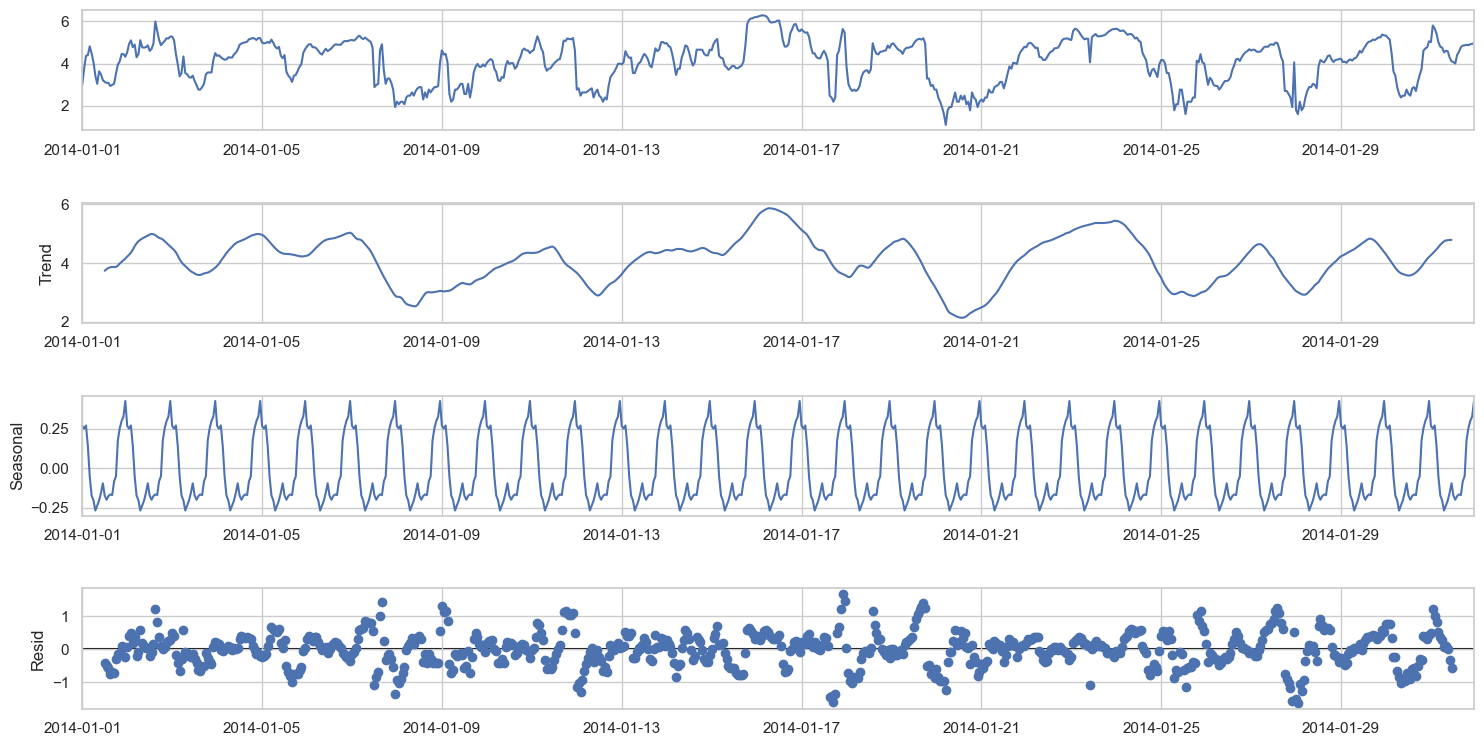

In [57]:
decomposition = seasonal_decompose(train_PM_log)
decomposition_2014_01 = seasonal_decompose(train_PM_log.loc["2014-01"])
fig = plt.figure()  
fig = decomposition_2014_01.plot()  
fig.set_size_inches(15, 8)

It seems to have a seasonal component of 24h cycle

In [58]:
residual = decomposition.resid

In [59]:
train_PM_log_decompose = residual
train_PM_log_decompose_moving_average_mean = train_PM_log_decompose.rolling(24).mean()
train_PM_log_decompose_moving_average_std = train_PM_log_decompose.rolling(24).std()

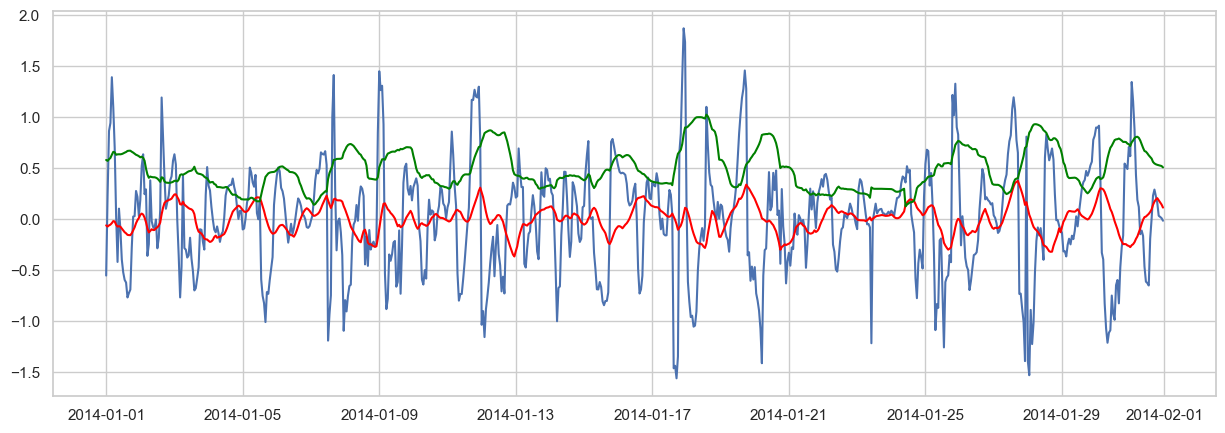

In [60]:
plt.plot(train_PM_log_decompose.dropna().loc["2014-01"])
plt.plot(train_PM_log_decompose_moving_average_mean.dropna().loc["2014-01"], color="red")
plt.plot(train_PM_log_decompose_moving_average_std.dropna().loc["2014-01"], color="green")

In [61]:
dftest_decomposed = adfuller(train_PM_log_moving_avg_diff.dropna(), autolag="AIC")

In [62]:
dfoutput_decomposed = pd.Series(dftest_decomposed[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations used"])

for key, value in dftest_decomposed[4].items():
    dfoutput_decomposed[f"Critical Value {key}"] = value

print(dfoutput_decomposed)
    

Test Statistic                   -22.424728
p-value                            0.000000
#Lags Used                        51.000000
Number of Observations used    34509.000000
Critical Value 1%                 -3.430540
Critical Value 5%                 -2.861624
Critical Value 10%                -2.566815
dtype: float64


## To plot the acf and pacf

### Let's define the parameters of ARIMA(p,d,q) using autocorrelation plot

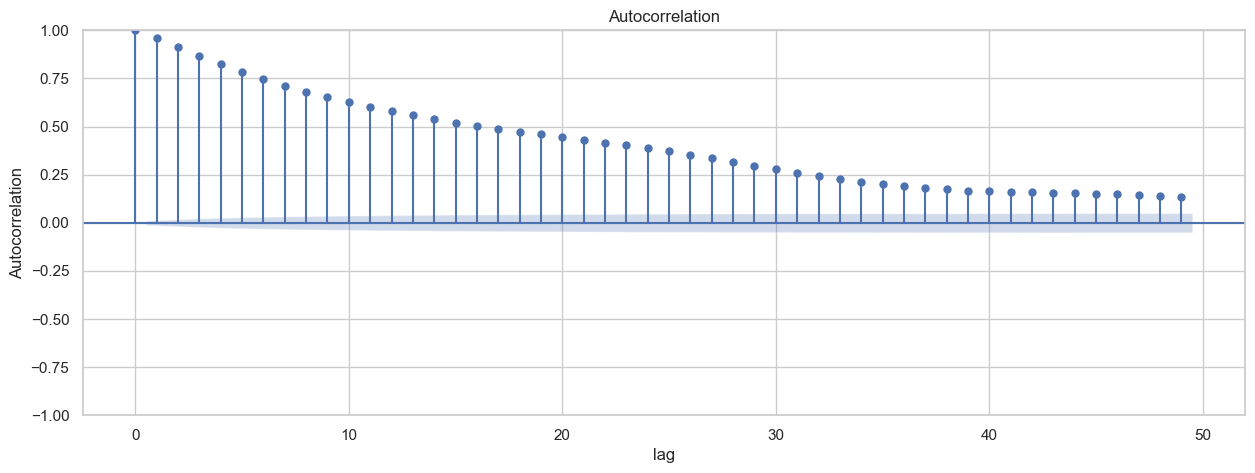

In [63]:
plot_acf(train_PM, alpha= 0.05, lags=49)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

First-order differencing 

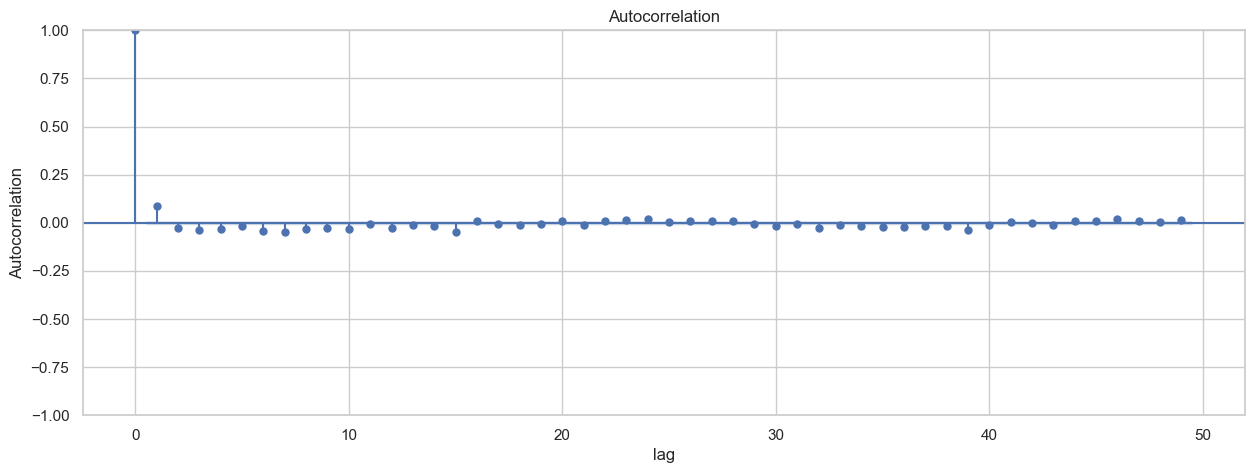

In [64]:
plot_acf(train_PM.diff().dropna(), alpha= 0.05, lags=49)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

Second-order differencing 

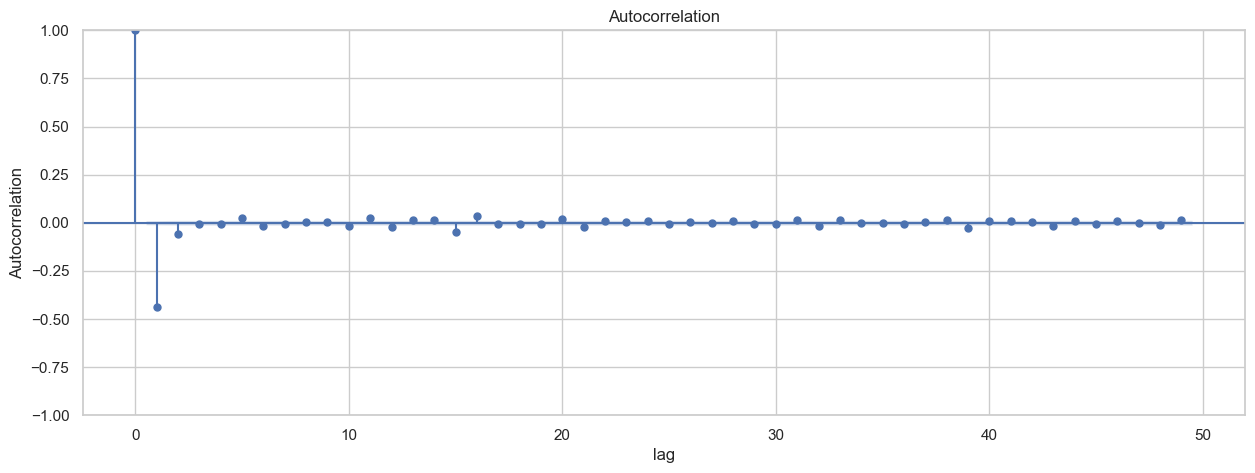

In [65]:
plot_acf(train_PM.diff().diff().dropna(), alpha= 0.05, lags=49)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

In [66]:
result = adfuller(train_PM)
print("No differencing: ", result)
result = adfuller(train_PM.diff().dropna())
print("First-order differencing: ", result)
result = adfuller(train_PM.diff().diff().dropna())
print("Second-order differencing: ",result)

No differencing:  (-19.030469242983266, 0.0, 51, 34676, {'1%': -3.4305385968435593, '5%': -2.861623355119825, '10%': -2.566814367314772}, 314759.36134942545)
First-order differencing:  (-33.68791268839843, 0.0, 52, 34674, {'1%': -3.4305386077226507, '5%': -2.86162335992796, '10%': -2.5668143698740185}, 315105.88449093356)
Second-order differencing:  (-48.0259366236193, 0.0, 52, 34673, {'1%': -3.430538613162667, '5%': -2.861623362332236, '10%': -2.566814371153752}, 316187.4560895074)


The statistic test and p-value are way below threshold in all differencing condition. However, the no differencing condition shows to many lags correlated and the second-order is probably over differencing. In our ARIMA model, we will probably use d=1.

### Let's define ARIMA parameters p and q

#### With the original PM2.5 data

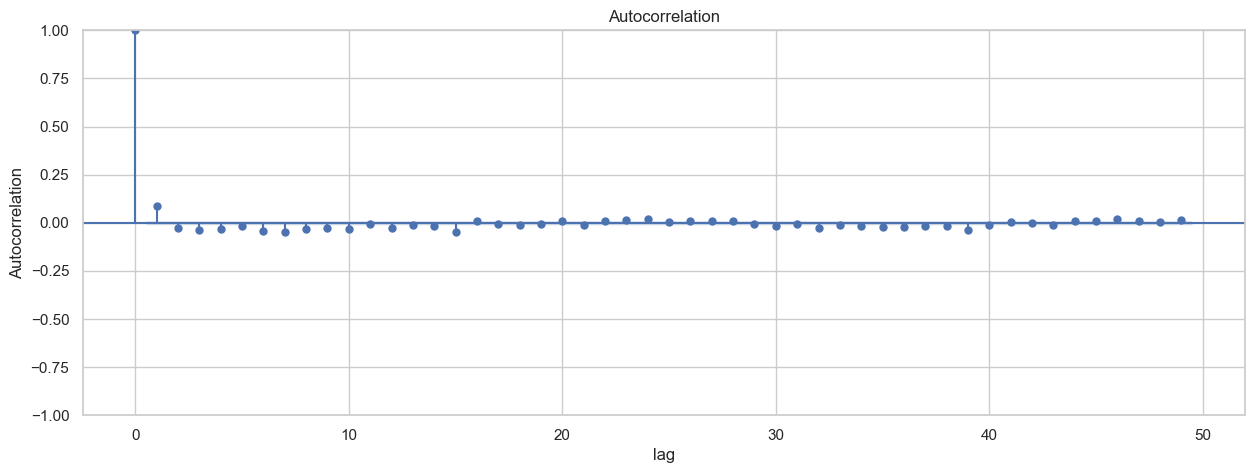

In [67]:
plot_acf(train_PM.diff().dropna(), alpha= 0.05, lags=49)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

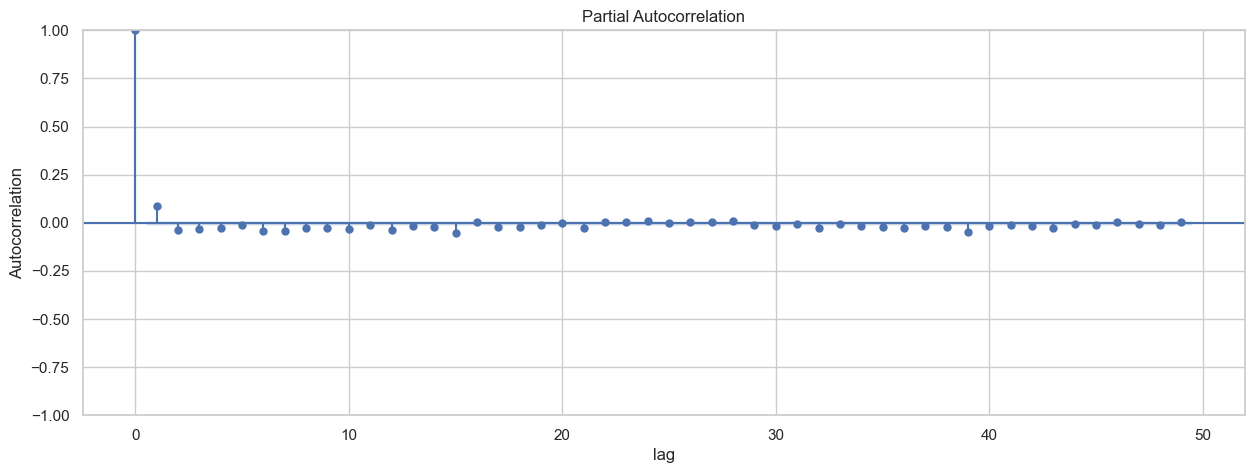

In [68]:
plot_pacf(train_PM.diff().dropna(), alpha= 0.05, lags=49, method="ols")
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

The acf and pacf plot using the original PM2.5 data show that lag 1 is most significant (above the threshold) 

If we will be using the original PM2.5 for ARIMA(p,d,q) prediction, we will set up p=1 and q=1 (with d=1) 

#### With the log transformed PM2.5 data

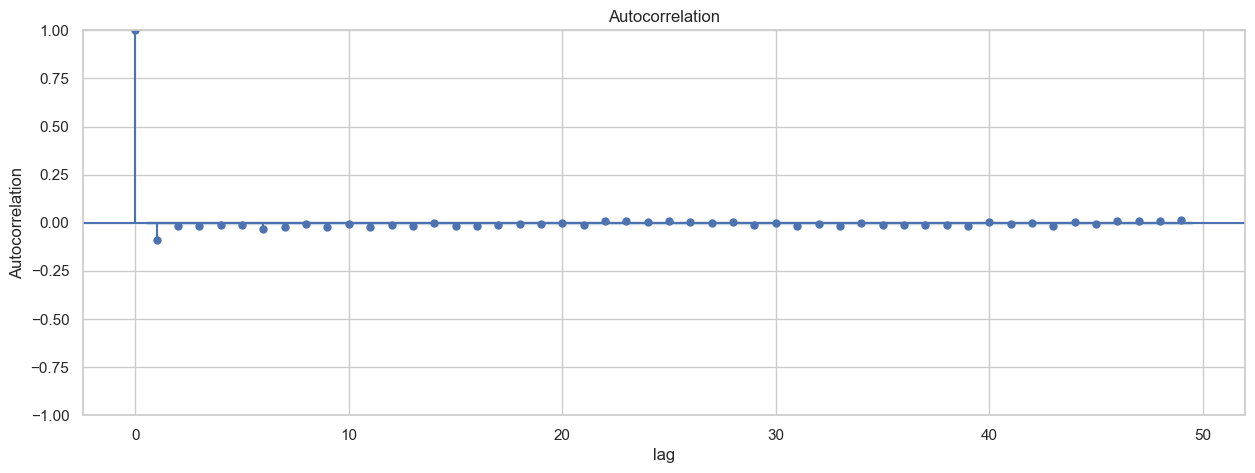

In [69]:
plot_acf(train_PM_log_diff.dropna(), alpha= 0.05, lags=49)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

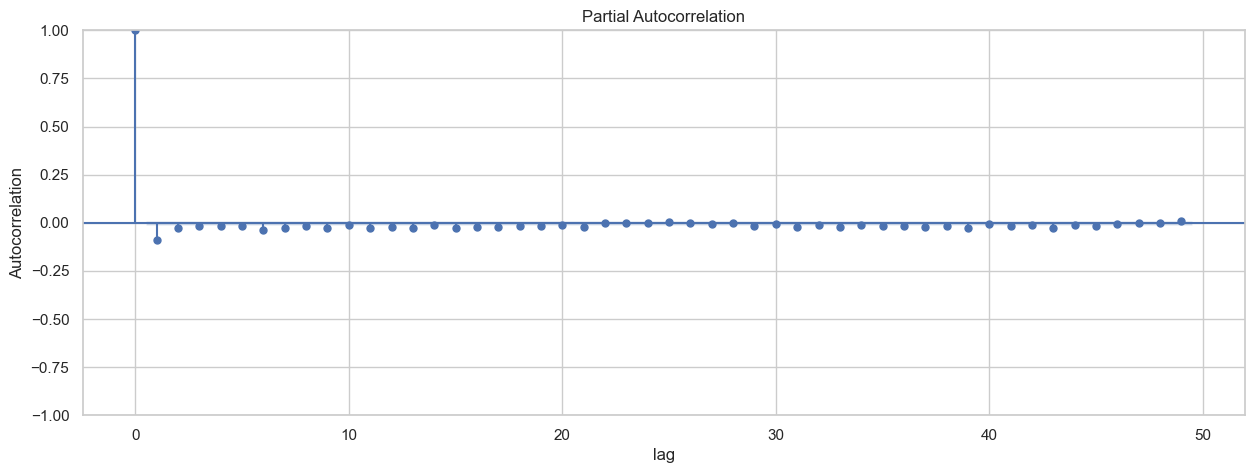

In [70]:
plot_pacf(train_PM_log.diff().dropna(), alpha= 0.05, lags=49, method="ols")
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

The acf and pacf plot using the log transfromed PM2.5 data show no significatn lags 

If using the log transformed data, we will probably use p=0 and q=0

## To test the selected p, d and q Arima parameters with in-sample predictions

In [71]:
arima_model_original = ARIMA(train_PM, order=(1,1,1), freq="H")
model_original = arima_model_original.fit()
print(model_original.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                34728
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -158129.646
Date:                Wed, 11 Jan 2023   AIC                         316265.293
Time:                        09:06:14   BIC                         316290.658
Sample:                    03-01-2013   HQIC                        316273.375
                         - 02-14-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1591      0.016    -10.060      0.000      -0.190      -0.128
ma.L1          0.2516      0.015     16.352      0.000       0.221       0.282
sigma2       528.0828      0.705    748.776      0.0

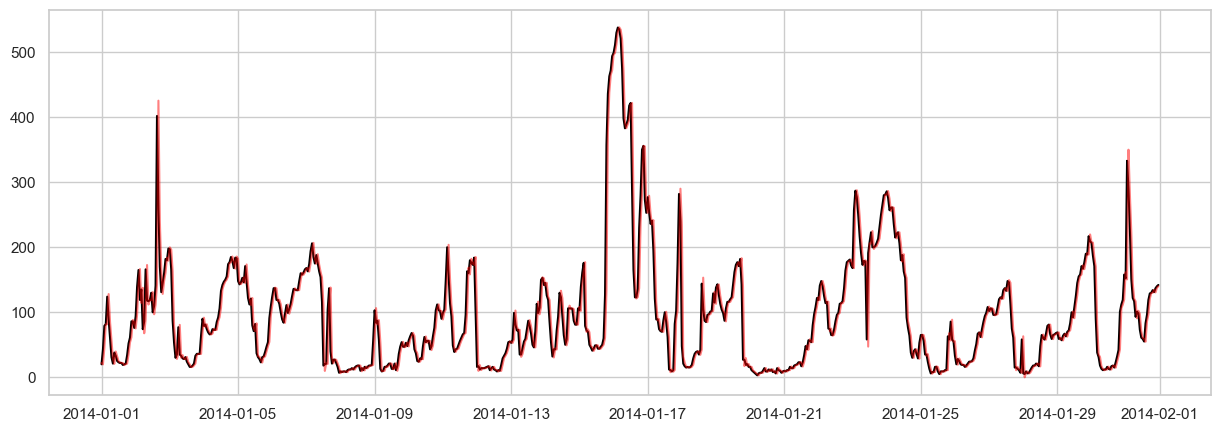

In [72]:
plt.plot(train_PM.loc["2014-01"], color="black")
plt.plot(model_original.predict().loc["2014-01"], color="red", alpha=0.5)

In [73]:
mean_absolute_error(train_PM, model_original.predict())

11.49217103860027

In [74]:
arima_model_logged = ARIMA(train_PM_log, order=(0,1,0), freq="H")
model_logged = arima_model_logged.fit()
print(model_logged.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                34728
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -13521.205
Date:                Wed, 11 Jan 2023   AIC                          27044.409
Time:                        09:06:30   BIC                          27052.864
Sample:                    03-01-2013   HQIC                         27047.103
                         - 02-14-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1276      0.000    377.753      0.000       0.127       0.128
Ljung-Box (L1) (Q):                 284.87   Jarque-Bera (JB):            303108.90
Prob(Q):                              0.00   Pr

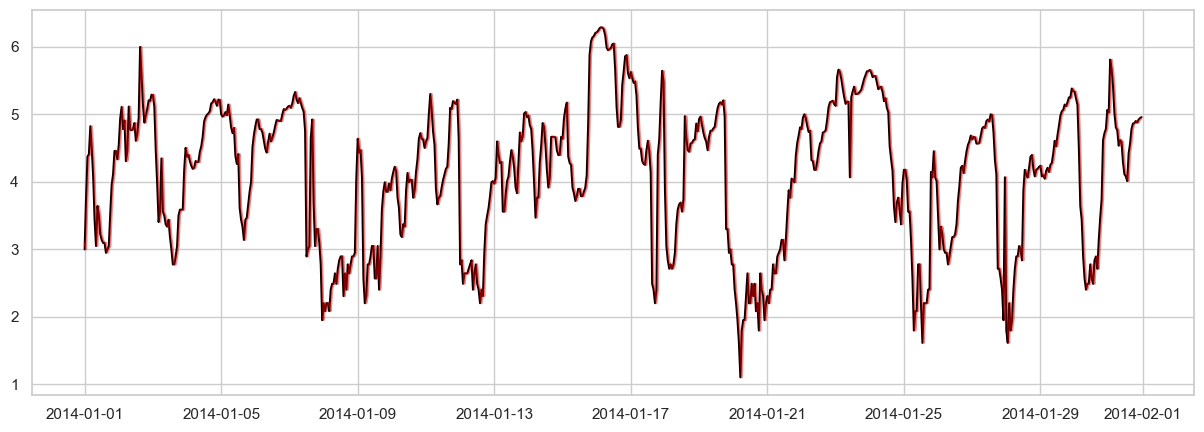

In [75]:
plt.plot(train_PM_log.loc["2014-01"], color="black")
plt.plot(model_logged.predict().loc["2014-01"], color="red", alpha=0.5)

In [76]:
mean_absolute_error(train_PM_log, model_logged.predict())

0.21085778267913927

Arima model perform better using the log transformed PM2.5 dataset

##  Seasonal

Let's see if our dataset has other seasonal partners

### Is PM2.5 changed along the month of the year?

<AxesSubplot: xlabel='date'>

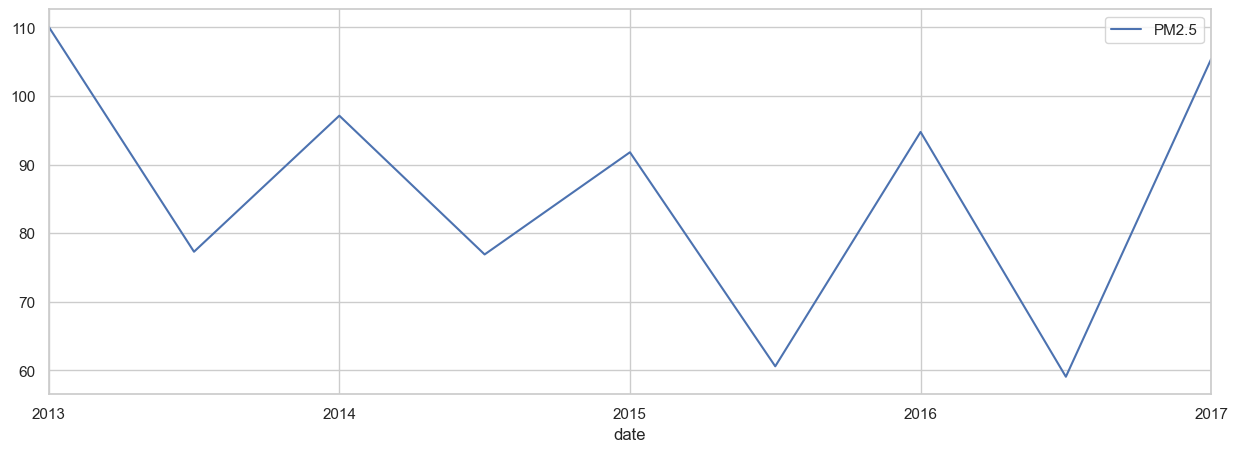

In [77]:
train_PM.resample('2Q').mean().plot()

It seems that there is a seasonal component of PM2.5 emission. PM2.5 decrease during the first 6 months of each year to then increase the last 6 months.

It might be that during winter time, people need to more energy to warm up their home or cars and therefore energy supply is increasing which could lead to increase of polution by industry that produce energy. 

In [78]:
train_PM_group = train_PM.groupby(train_PM.index.month)

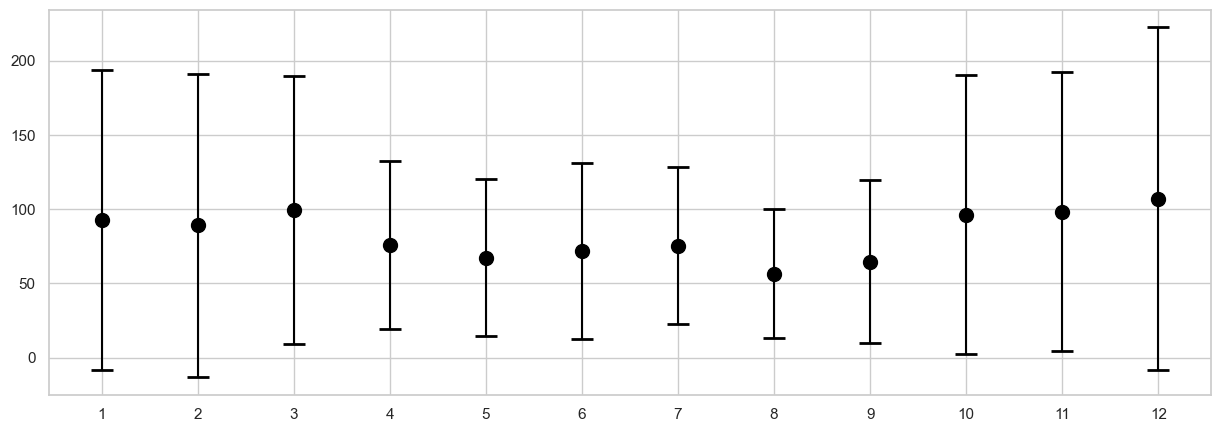

In [79]:
plt.figure(figsize=(15,5))
plt.errorbar(x=list(train_PM_group.mean().index), y=train_PM_group.mean()["PM2.5"], yerr=train_PM_group.std()["PM2.5"],
            fmt='o', capsize=8, capthick=2, color='black', markersize=10)
plt.xticks(list(train_PM_group.mean().index))
ax = plt.gca()
ticks = ax.set_xticklabels(train_PM_group.mean().index);

It appears that PM2.5 pollution is higher during winter time  

### Is wind speed changed along the month of the year?

In [80]:
train_exog_group = train_exog.groupby(train_exog.index.month)

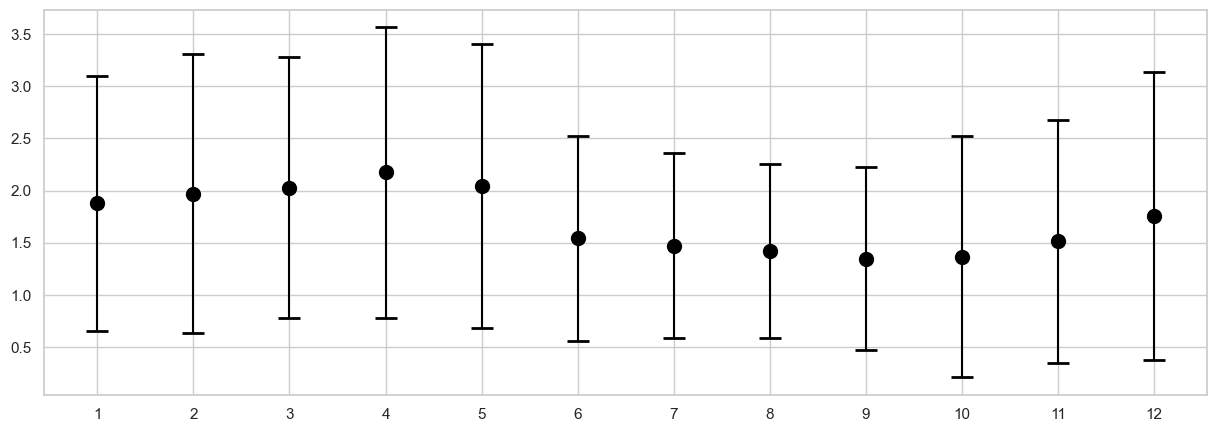

In [81]:
plt.figure(figsize=(15,5))
plt.errorbar(x=list(train_exog_group.mean().index), y=train_exog_group.mean(), yerr=train_exog_group.std(),
            fmt='o', capsize=8, capthick=2, color='black', markersize=10)
plt.xticks(list(train_exog_group.mean().index))
ax = plt.gca()
ticks = ax.set_xticklabels(train_exog_group.mean().index);


Wind speed increases from november until April-May, with the highest peak in April

Although PM2.5 pollution is higher during winter time (probably due to increase in energy consumption), Pm2.5 starts decreasing in April when wind speed is at its highest. 

### Comparision between PM2.5 pollution and wind speed 

If now we compare the PM2.5 emmission and the wind speed forecast, we can see clearly that there is anti-correlation between PM2.5 polution and wind speed forecast, especially in 2015 and 2016

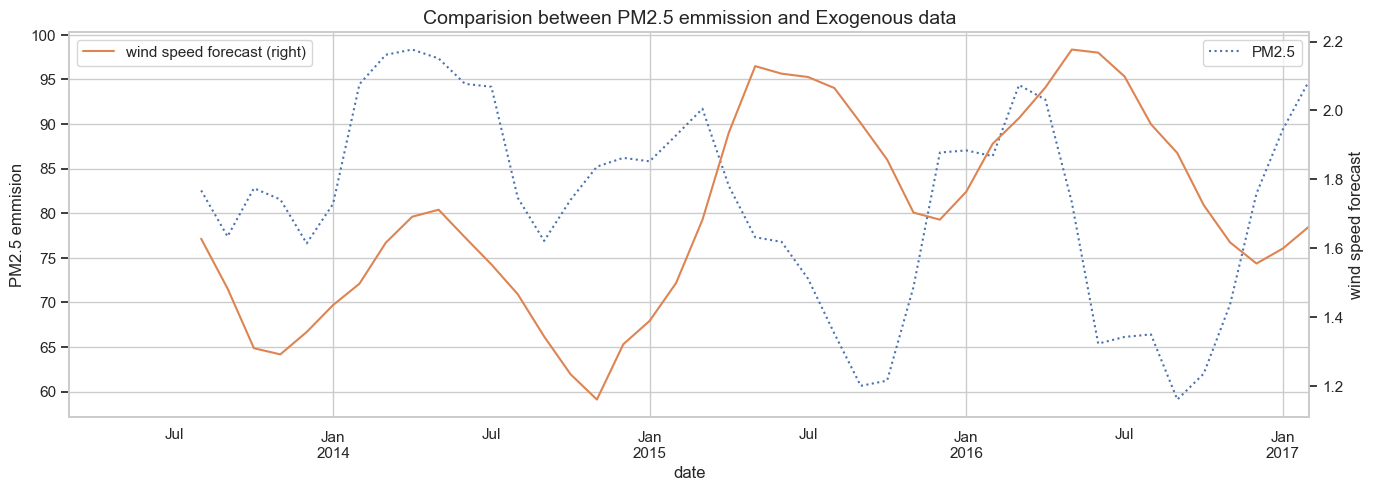

In [82]:
train_PM.resample("M").mean().rolling(6).mean().plot(ls=':', label="PM2.5 emmision")
plt.ylabel("PM2.5 emmision")
data_exog.resample("M").mean().rolling(6).mean().plot(figsize=(16, 5), secondary_y=True, label="wind speed forecast")
plt.ylabel("wind speed forecast")
plt.title('Comparision between PM2.5 emmission and Exogenous data', size=14)
plt.legend();

This anti-correlation is not present for the year 2014, probably because the average wind speed was below speed threshold this year to clear efficiently the PM2.5 polution 

### Is PM2.5 changed during weekdays and weekends?

In [83]:
train_PM_we = train_PM.groupby(train_PM.index.dayofweek)

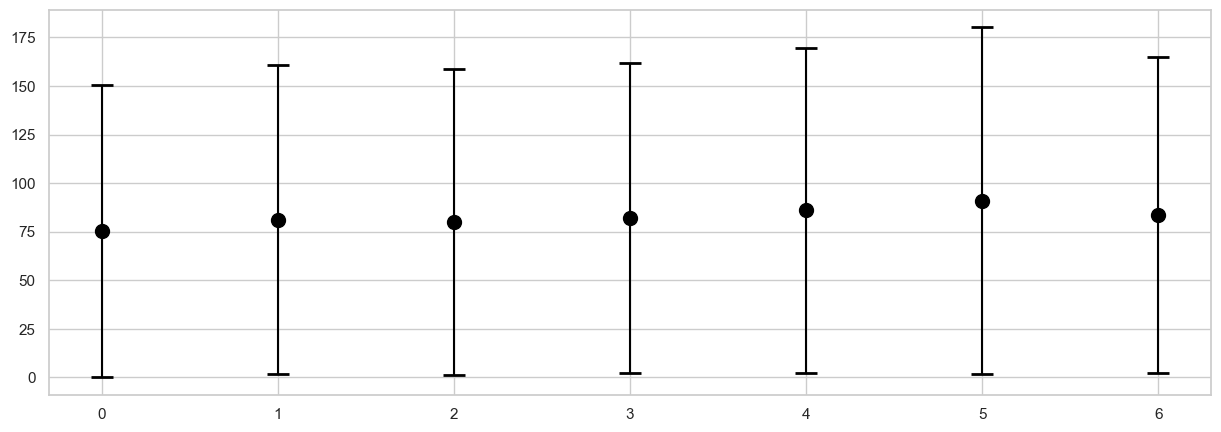

In [84]:
plt.figure(figsize=(15,5))
plt.errorbar(x=list(train_PM_we.mean().index), y=train_PM_we.mean()["PM2.5"], yerr=train_PM_we.std()["PM2.5"],
            fmt='o', capsize=8, capthick=2, color='black', markersize=10)
plt.xticks(list(train_PM_we.mean().index))
ax = plt.gca()
ticks = ax.set_xticklabels(train_PM_we.mean().index);

Although, car traffic should be more intense during weekdays (because of working days), there is slightly more pollution during the weekend than weekdays.  

### Is PM2.5 changed during the day?

Does traffic hours (8h-9h and 18h-19h) affect the level of PM2.5 pollution ? 

In [85]:
train_PM_hrs = train_PM.groupby(train_PM.index.hour)

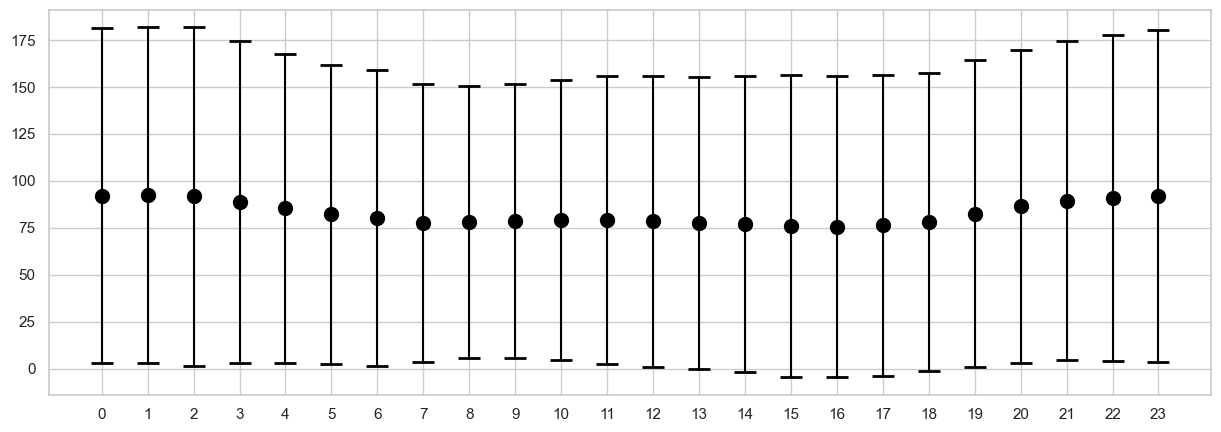

In [86]:
plt.figure(figsize=(15,5))
plt.errorbar(x=list(train_PM_hrs.mean().index), y=train_PM_hrs.mean()["PM2.5"], yerr=train_PM_hrs.std()["PM2.5"],
            fmt='o', capsize=8, capthick=2, color='black', markersize=10)
plt.xticks(list(train_PM_hrs.mean().index))
ax = plt.gca()
ticks = ax.set_xticklabels(train_PM_hrs.mean().index);

We can see a slight decrease of the PM2.5 emission during daytime

### Is wind speed changed during the day?

In [87]:
exog_hrs = train_exog.groupby(train_exog.index.hour)

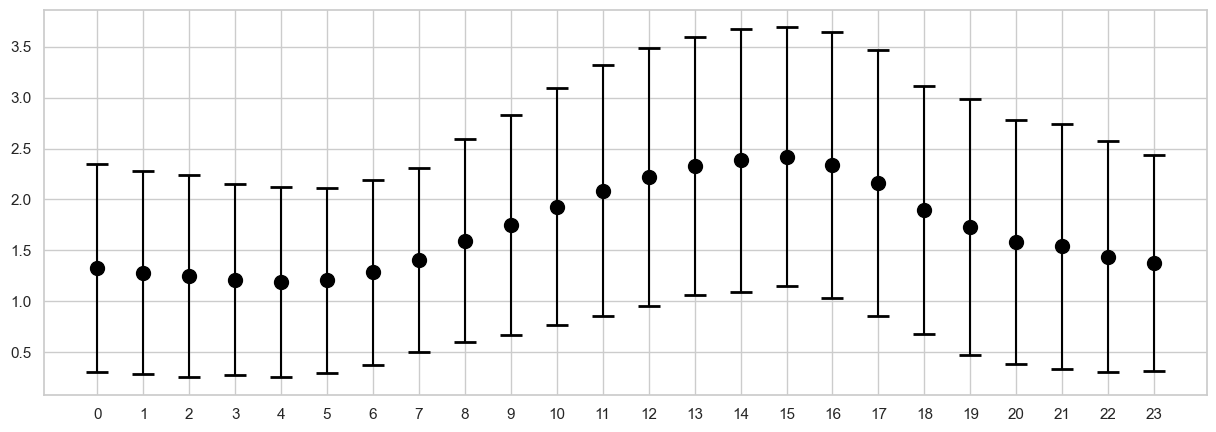

In [88]:
plt.figure(figsize=(15,5))
plt.errorbar(x=list(exog_hrs.mean().index), y=exog_hrs.mean(), yerr=exog_hrs.std(),
            fmt='o', capsize=8, capthick=2, color='black', markersize=10)
plt.xticks(list(exog_hrs.mean().index))
ax = plt.gca()
ticks = ax.set_xticklabels(exog_hrs.mean().index);

The wind speed increase during daytime to peak at 15h (or 3pm). In contrast, the wind speed decrease during night time. Increase in wind speed seems correlated with lower PM2.5 pollution during the day.

This shows that exogenous dataset will be crucial for forecasting the last missing 168 values of the PM2.5

# Sarima and Sarimax models

## Sarima

First let's split the train dataset into train and validation (on a small subset)

I will perfom the train validation on a small subset to make the calculation faster for autoARIMA

In [84]:
train_test, val_test = train_PM_log[:1000], train_PM_log[1000:2000]

If we used the log transformed PM2.5 dataset, we don't need differencing the data and therefore d should be set up at d=0
If we used the non tranformfed data, I  need to set up d=1 as we observed above that First-order differencing was enough to make the data stationary.

And as we see a 24h period in the decomposition plot (m=24)

In [283]:
model_sarima = pm.AutoARIMA(trace=True, supress_warnings=True, d=0,  m=24)

model_sarima.fit(train_test)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=5.10 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=3299.245, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=1111.504, Time=1.72 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=2350.820, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=5698.917, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=1109.506, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=1111.504, Time=1.41 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=1104.114, Time=0.11 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=1106.087, Time=2.39 sec
 ARIMA(2,0,0)(0,0,1)[24] intercept   : AIC=1106.087, Time=1.39 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=3.37 sec
 ARIMA(3,0,0)(0,0,0)[24] intercept   : AIC=1103.802, Time=0.17 sec
 ARIMA(3,0,0)(1,0,0)[24] intercept   : AIC=1105.753, Time=2.90 sec
 ARIMA(3,0,0)(0,0,1)[24] intercept

AutoARIMA(d=0, m=24, trace=True)

In [284]:
sarima_forecast = model_sarima.predict(1000)

In [285]:
mean_absolute_error(np.exp(sarima_forecast), np.exp(val_test))

46.779381648739815

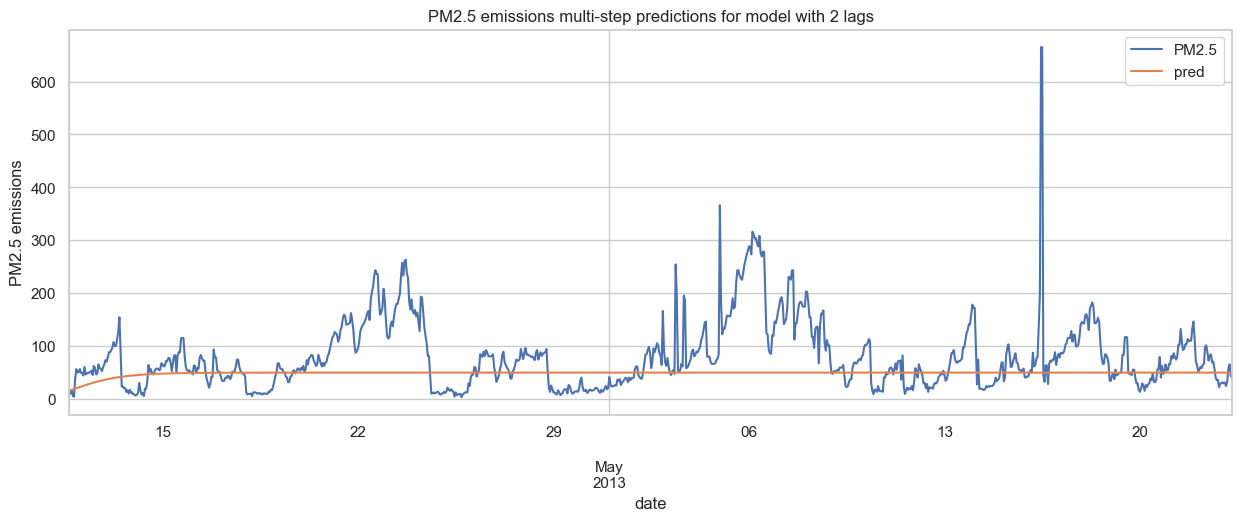

In [286]:
np.exp(val_test).plot(label="original data")
plt.ylabel('PM2.5 emissions')
pd.Series(np.exp(sarima_forecast), index=val_test.index).plot(label="pred")
plt.title('PM2.5 emissions multi-step predictions for model with 2 lags')
plt.legend();

The PM2.5 predictions are really bad, let's try to include the exogenous dataset of the wind speed forecast

## Sarimax

First let's split the exog data in exog_train and exog_val as for the train dataset

In [97]:
train_test, val_test = train_PM_log[:1000], train_PM_log[1000:2000]

In [98]:
exog_train_test, exog_val_test = train_exog[:1000], train_exog[1000:2000]

In [99]:
sarimax_model = pm.AutoARIMA(trace=True, supress_warnings=True, d=0, m=24)

sarimax_model.fit(train_test ,pd.DataFrame(exog_train_test)) 


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=1110.907, Time=6.12 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=3173.042, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=1112.514, Time=2.38 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=2303.804, Time=1.29 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=4910.645, Time=0.08 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=1109.037, Time=3.14 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=1107.083, Time=0.33 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=1109.038, Time=3.07 sec
 ARIMA(1,0,2)(0,0,0)[24] intercept   : AIC=1105.206, Time=0.32 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=1107.163, Time=2.94 sec
 ARIMA(1,0,2)(0,0,1)[24] intercept   : AIC=1107.163, Time=2.71 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=1109.196, Time=3.35 sec
 ARIMA(0,0,2)(0,0,0)[24] intercept   : AIC=1893.689, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=1104.664, Time=0.26 sec
 ARIMA(1,0,1)(1,0,0

AutoARIMA(d=0, m=24, trace=True)

In [100]:
sarimax_model_forecast = sarimax_model.predict(1000, pd.DataFrame(exog_val_test)) 

In [101]:
mean_absolute_error(np.exp(sarimax_model_forecast), np.exp(val_test))

46.50996226377015

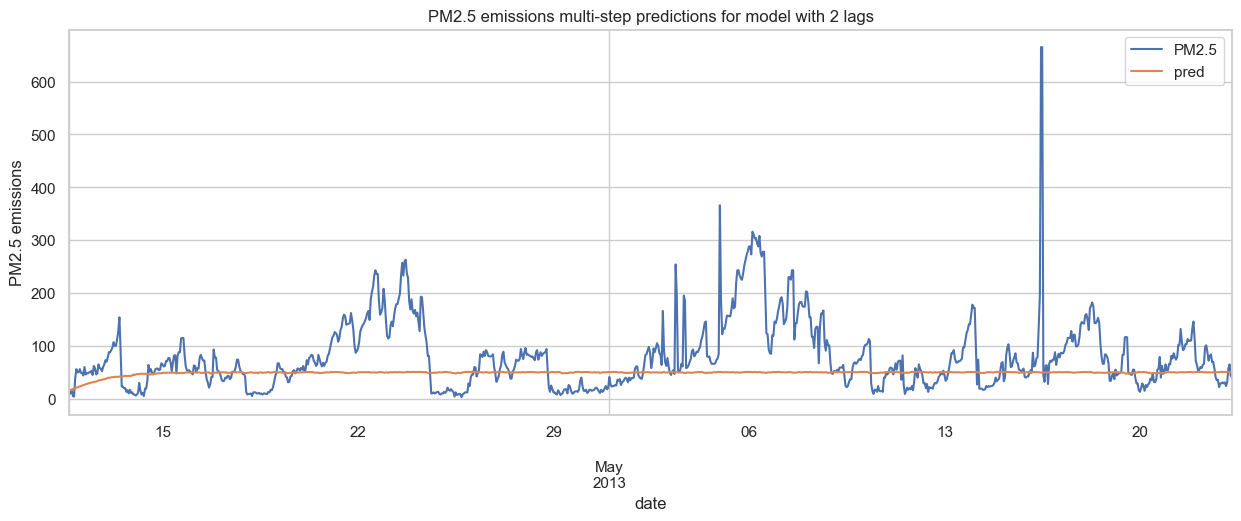

In [102]:
np.exp(val_test).plot(label="original data")
plt.ylabel('PM2.5 emissions')
pd.Series(np.exp(sarimax_model_forecast), index=val_test.index).plot(label="pred")
plt.title('PM2.5 emissions multi-step predictions for model with 2 lags')
plt.legend();

The predictions are still very bad even with the exogenous wind speed forecast prediction

## Sarimax with features enginnering of exog variables

Let's try to include some features engineering of the exog features 

In [407]:
train_exog_fe = pd.DataFrame(train_exog.copy())

In [408]:
train_exog_fe

,exog
date,
2013-03-01 00:00:00,4.4
2013-03-01 01:00:00,4.7
2013-03-01 02:00:00,5.6
2013-03-01 03:00:00,3.1
2013-03-01 04:00:00,2.0
...,...
2017-02-14 19:00:00,1.1
2017-02-14 20:00:00,0.2
2017-02-14 21:00:00,1.0


To create new features from the exog variables (rolling_mean, rolling_std and exog_lead)

In [409]:
train_exog_fe["exog_rolling_24"] = train_exog_fe["exog"].rolling(24, min_periods=1).mean()
train_exog_fe["exog_rolling_24_std"] = train_exog_fe["exog"].rolling(24, min_periods=1).std()
train_exog_fe["exog_lead_1"] = train_exog_fe["exog"].shift(-1)
train_exog_fe["exog_lead_2"] = train_exog_fe["exog"].shift(-2)
train_exog_fe["exog_lead_7"] = train_exog_fe["exog"].shift(-7)
train_exog_fe["exog_lead_24"] = train_exog_fe["exog"].shift(-7)

In order to deal with the missing values created by exog_lead features, I will just replace the missing values of exog_lead with the corresponding exog values of the timestamp

In [410]:
for index, row in train_exog_fe.iterrows():
    if np.isnan(row["exog_lead_1"]):
        train_exog_fe.loc[index, "exog_lead_1"] = train_exog_fe.loc[index, "exog"]
    if np.isnan(row["exog_lead_2"]):
        train_exog_fe.loc[index, "exog_lead_2"] = train_exog_fe.loc[index, "exog"]
    if np.isnan(row["exog_lead_7"]):
        train_exog_fe.loc[index, "exog_lead_7"] = train_exog_fe.loc[index, "exog"]
    if np.isnan(row["exog_lead_24"]):
        train_exog_fe.loc[index, "exog_lead_24"] = train_exog_fe.loc[index, "exog"]
        
train_exog_fe["exog_rolling_24_std"] = train_exog_fe["exog_rolling_24_std"].fillna(0)

In [411]:
train_exog_fe

,exog,exog_rolling_24,exog_rolling_24_std,exog_lead_1,exog_lead_2,exog_lead_7,exog_lead_24
date,,,,,,,
2013-03-01 00:00:00,4.4,4.400000,0.000000,4.7,5.6,3.8,3.8
2013-03-01 01:00:00,4.7,4.550000,0.212132,5.6,3.1,4.1,4.1
2013-03-01 02:00:00,5.6,4.900000,0.624500,3.1,2.0,2.6,2.6
2013-03-01 03:00:00,3.1,4.450000,1.034408,2.0,3.7,3.6,3.6
2013-03-01 04:00:00,2.0,3.960000,1.415274,3.7,2.5,3.7,3.7
...,...,...,...,...,...,...,...
2017-02-14 19:00:00,1.1,1.270833,0.504311,0.2,1.0,1.1,1.1
2017-02-14 20:00:00,0.2,1.254167,0.533226,1.0,1.0,0.2,0.2
2017-02-14 21:00:00,1.0,1.254167,0.533226,1.0,0.8,1.0,1.0


To perform Sarimax model using this new exogenous variables and using AutoArima to set up hyperparameters

In [532]:
train_test, val_test = train_PM_log[:1000], train_PM_log[1000:2000]

In [533]:
exog_train_test, exog_val_test = train_exog_fe[:1000], train_exog_fe[1000:2000]

In [534]:
sarimax_model_fe = pm.AutoARIMA(trace=True, supress_warnings=True, d=0, m=24)

sarimax_model_fe.fit(train_test ,pd.DataFrame(exog_train_test))

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=1097.984, Time=9.54 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=2761.994, Time=0.36 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=1096.607, Time=5.88 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=1941.860, Time=5.40 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=4424.469, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=1094.608, Time=0.62 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=1096.607, Time=5.73 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=1098.608, Time=5.97 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=1091.026, Time=0.77 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=1093.026, Time=7.12 sec
 ARIMA(2,0,0)(0,0,1)[24] intercept   : AIC=1093.025, Time=6.28 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=1095.006, Time=6.91 sec
 ARIMA(3,0,0)(0,0,0)[24] intercept   : AIC=1089.211, Time=1.00 sec
 ARIMA(3,0,0)(1,0,0)[24] intercept   : AIC=1091.290, Time=7.84 sec
 ARIMA(3,0,0)(0,0,1

AutoARIMA(d=0, m=24, trace=True)

In [535]:
sarimax_model_fe_forecast = sarimax_model_fe.predict(1000, pd.DataFrame(exog_val_test))

In [536]:
mean_absolute_error(np.exp(sarimax_model_fe_forecast), np.exp(val_test))

43.23188341447414

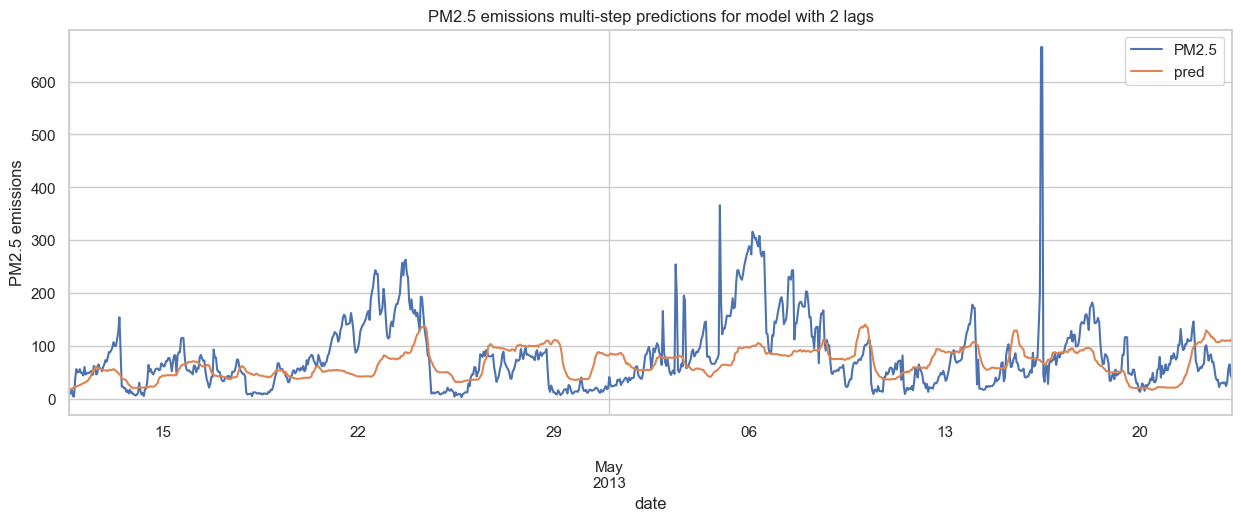

In [537]:
np.exp(val_test).plot(label="original data")
plt.ylabel('PM2.5 emissions')
pd.Series(np.exp(sarimax_model_fe_forecast), index=val_test.index).plot(label="pred")
plt.title('PM2.5 emissions multi-step predictions for model with 2 lags')
plt.legend();

## Out-sample predictions using Sarimax with features engineering of exog variables 

Let's try to perfom out-of-sample predictions using Sarimax model and with features engineered variables from exog

First, let's split again the data into train (9832 time series values) and test (with the 168 missing PM2.5 values to be predicted)

In [541]:
train_out , test_out = train_PM_log[-10000:-168], train_PM_log[-168:]

In [542]:
exog_train_out, exog_test_out = train_exog_fe[-10000:-168], train_exog_fe[-168:]

In [543]:
sarimax_model_fe_out = pm.AutoARIMA(trace=True, supress_warnings=True, d=0, m=24)

sarimax_model_fe_out.fit(train_out ,pd.DataFrame(exog_train_out))

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=8130.609, Time=82.31 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=25603.131, Time=4.27 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=8260.699, Time=51.39 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=17192.710, Time=45.50 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=42899.815, Time=2.57 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=8129.686, Time=240.70 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=8128.090, Time=8.49 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=8129.680, Time=68.16 sec
 ARIMA(1,0,2)(0,0,0)[24] intercept   : AIC=8126.038, Time=8.58 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=8128.158, Time=457.28 sec
 ARIMA(1,0,2)(0,0,1)[24] intercept   : AIC=8127.631, Time=76.44 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=8128.365, Time=353.00 sec
 ARIMA(0,0,2)(0,0,0)[24] intercept   : AIC=13917.454, Time=5.50 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=8124.252, Time=7.58 sec
 ARI

AutoARIMA(d=0, m=24, trace=True)

In [544]:
sarimax_model_fe_out_forecast = sarimax_model_fe_out.predict(168, pd.DataFrame(exog_test_out))

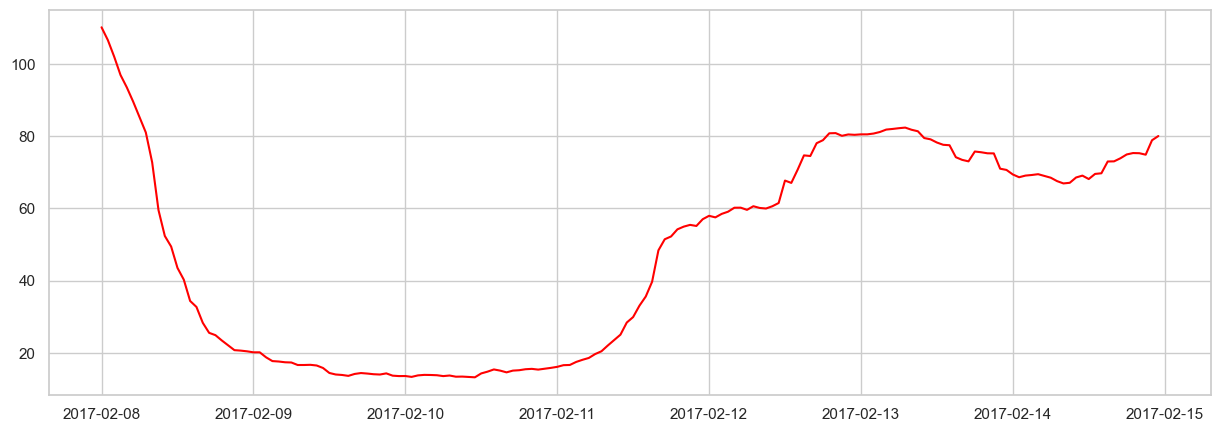

In [546]:
plt.plot(pd.Series(np.exp(sarimax_model_fe_out_forecast), index=train_PM_log.index), color="red")

In [550]:
pd.Series(np.exp(sarimax_model_fe_out_forecast)).to_frame(name="PM2.5").to_csv(path_to_save + "/submission_sarimax.csv", index=False)
          

# Regression model

As my attempt using Sarima or Sarimax models did not result well enough, I will set up Regression models to predicts the 168 missing PM2.5 time serie values

First, let's retrieve the train dataset for PM2.5

In [52]:
train_PM

,PM2.5
date,
2013-03-01 00:00:00,4.0
2013-03-01 01:00:00,8.0
2013-03-01 02:00:00,7.0
2013-03-01 03:00:00,6.0
2013-03-01 04:00:00,3.0
...,...
2017-02-14 19:00:00,210.0
2017-02-14 20:00:00,211.0
2017-02-14 21:00:00,227.0


Then, the full exog dataset as a dataframe (including the 168 timestamps where PM2.5 values are missing) 

In [53]:
data_exog_df = pd.DataFrame(data_exog)
data_exog_df

,exog
date,
2013-03-01 00:00:00,4.4
2013-03-01 01:00:00,4.7
2013-03-01 02:00:00,5.6
2013-03-01 03:00:00,3.1
2013-03-01 04:00:00,2.0
...,...
2017-02-21 19:00:00,1.4
2017-02-21 20:00:00,1.5
2017-02-21 21:00:00,1.1


To finally concatenate the full dataset for PM2.5 and exog values (in which KNNImputer was applied)

In [54]:
all_data_time_series = pd.concat([train_PM,data_exog_df], axis=1)

In [55]:
all_data_time_series

,PM2.5,exog
date,,
2013-03-01 00:00:00,4.0,4.4
2013-03-01 01:00:00,8.0,4.7
2013-03-01 02:00:00,7.0,5.6
2013-03-01 03:00:00,6.0,3.1
2013-03-01 04:00:00,3.0,2.0
...,...,...
2017-02-21 19:00:00,NaN,1.4
2017-02-21 20:00:00,NaN,1.5
2017-02-21 21:00:00,NaN,1.1


# Feature engineering

## Feature engineering for datetime & exog variables and train-test split

To create a function that create new features (is_summer, is_weekend, is_daytime...), train-test split the data and finally to perform a Regression model using a for loop to predict one out-of-sample at the time and update the rolling_PM2.5 new feature in the test dataset

In [131]:
def  feature_dt_exog(df_, rollings=48, num_periods_lead=1, diff=48, split=168, target="PM2.5"):
    
    # make a copy 
    df_ = df_.copy()
    
    # create is_weekend feature
    df_["day_of_week"] = df_.index.weekday
    df_["is_weekend"] = df_.day_of_week.apply(lambda x : 0 if x in range(0,5) else 1)
    df_ = df_.drop(columns="day_of_week")
    
    # Circular Encoding of the weekday
    df_['sin_weekday'] = np.sin(2*np.pi*df_.index.weekday/7)
    df_['cos_weekday'] = np.cos(2*np.pi*df_.index.weekday/7)
    
    # create is_summer feature
    df_["month"] = df_.index.month
    df_["is_summer"] = df_.month.apply(lambda x : 1 if x in range(4,10) else 0)
    df_ = df_.drop(columns="month")
    
    # Circular Encoding of the month
    df_['sin_month'] = np.sin(2*np.pi*df_.index.month/12)
    df_['cos_month'] = np.cos(2*np.pi*df_.index.month/12)
    
    # create is_daytime feature
    df_["hours"] = df_.index.hour
    df_["is_daytime"] = df_.hours.apply(lambda x : 1 if x in range(6,19) else 0)
    df_ = df_.drop(columns="hours")
    
    # Circular Encoding of the hours
    df_['sin_hour'] = np.sin(2*np.pi*df_.index.hour/24)
    df_['cos_hour'] = np.cos(2*np.pi*df_.index.hour/24)
    
    # create h rolling feature for PM2.5
    df_["rolling_PM"] = df_[target].rolling(rollings, min_periods=1).mean() 
    
    # create 7h rolling feature for exog
    df_["rolling_exog"] = df_["exog"].rolling(rollings, min_periods=1).mean() 
    
    #for a few values, get the lags  
    for i in range(1, num_periods_lead+1):
        # make a new feature, with the lags of the exog values column
        df_['exog_lead_%s' % str(i)] = df_['exog'].shift(-i)
        #df_['exog_lead_%s' % str(i)].fillna(method='ffill', inplace=True)
        for index, row in df_.iterrows():
            if np.isnan(row['exog_lead_%s' % str(i)]):
                df_.loc[index, 'exog_lead_%s' % str(i)] = df_.loc[index, "exog"]
    
    # create diff feature for exog (diff)
    df_["diff_exog"] = df_["exog"].diff(diff)
    
    # drop row with missing values in diff_exog feature
    df_ = df_.dropna(subset=["diff_exog"])
    
    # split the dataset into train and validation set
    train_, val_ = df_[:-split], df_[-split:] 
    
    # define the features and target
    train_feature, train_target = train_.drop(columns=target), train_[target]
    val_feature, val_target = val_.drop(columns=target), val_[target]
    
    
    # linear regression with for loop to update PM2.5 rolling feature in the test dataset
    last_47_PM = train_target.iloc[-rollings+1:].values.tolist()
    predictions = []
    for count in range(len(val_feature.index)-1):
        
        GBR = GradientBoostingRegressor(random_state=10, n_estimators=100)
        GBR.fit(train_feature, train_target)
        predict = GBR.predict(val_feature.iloc[count:count+1])
        predictions.append(predict[0])
        last_47_PM.append(predict[0])
        
        # the index of the rolling_PM is 10
        val_feature.iloc[count+1, 10] = sum(last_47_PM[-rollings:])/rollings
        
    # extra step out of the loop to predict the last timestamps
    predictions.append(GBR.predict(val_feature.iloc[-1:])[0])
        
    return predictions, val_feature

To test the regression model in validation set of the data

In [132]:
val_df = all_data_time_series.iloc[:-168].copy()

In this validation dataset, I will replace the last 168 values of PM2.5 to recreate the missing PM2.5 values of the test dataset

In [133]:
val_df.iloc[-168:,0] = np.nan

In [134]:
val, val_f = feature_dt_exog(val_df, rollings=48, num_periods_lead=7, diff=48, split=168, target="PM2.5")

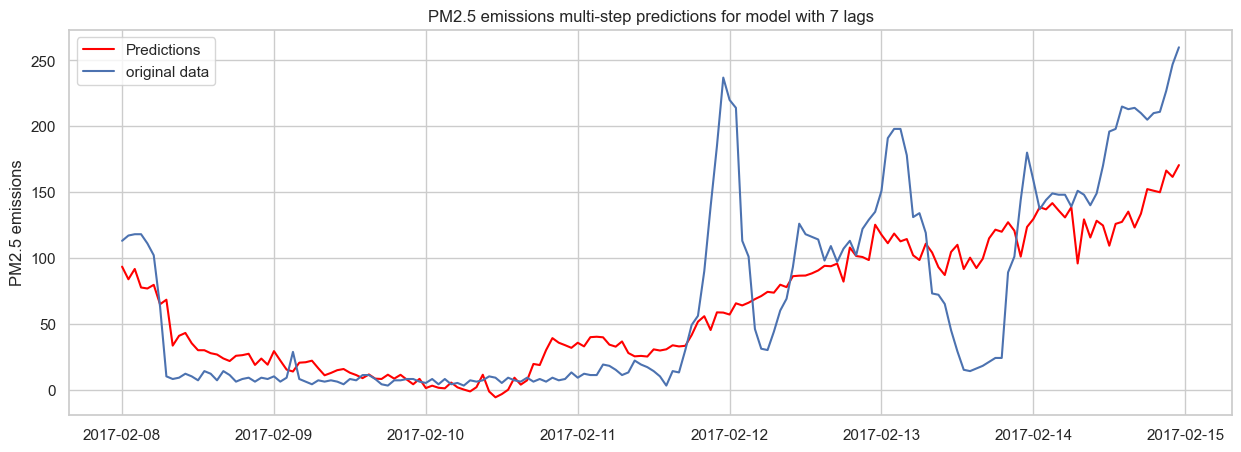

In [139]:
plt.plot(pd.Series(val, index=val_df[-168:].index), color="red", label="Predictions")
plt.plot(all_data_time_series.iloc[:-168][-168:]["PM2.5"], label="original data")
plt.ylabel('PM2.5 emissions')
plt.title('PM2.5 emissions multi-step predictions for model with 7 lags')
plt.legend();

In [145]:
print( "MAE = ", mean_absolute_error(all_data_time_series.iloc[:-168][-168:]["PM2.5"], (pd.Series(val, index=val_df[-168:].index))))

MAE =  30.152560760160572


To perform the regression model with the train-test dataset and predict the 168 Pm2.5 missing values

In [126]:
res, res_f = feature_dt_exog(all_data_time_series, rollings=48, num_periods_lead=7, diff=48, split=168, target="PM2.5")

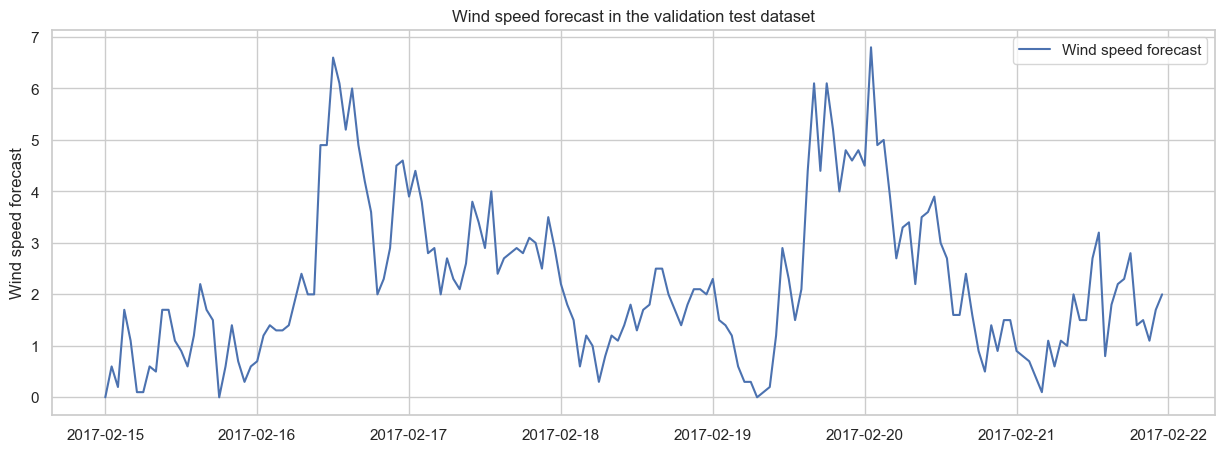

In [140]:
plt.plot(res_f["exog"], label="Wind speed forecast")
plt.ylabel('Wind speed forecast')
plt.title('Wind speed forecast in the validation test dataset')
plt.legend();

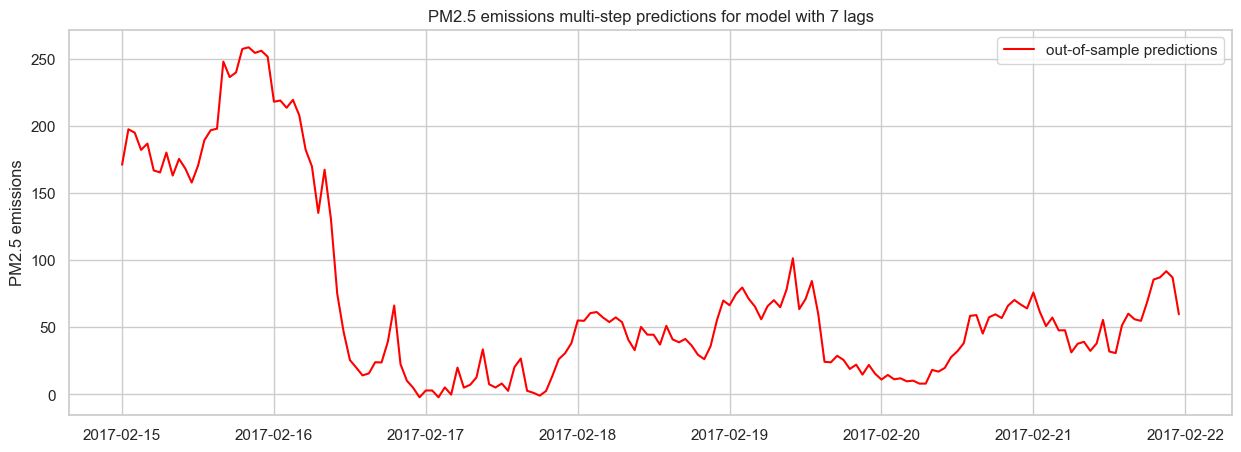

In [141]:
plt.plot(pd.Series(res, index=res_f.index), color="red", label="out-of-sample predictions")
plt.ylabel('PM2.5 emissions')
plt.title('PM2.5 emissions multi-step predictions for model with 7 lags')
plt.legend();

To save and export the predictions

In [129]:
path_to_save = '/Users/fabienguegan/projects/batch6-workspace/S03 - Time Series/HCKT03 - Time Series Forecasting'

In [130]:
 pd.Series(res, index=res_f.index).to_frame(name="PM2.5").to_csv(path_to_save + "/submission.csv", index=False)